In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import numpy as np
import datasets
import training.train_tabcbm as train_tabcbm
import pandas as pd
import os
from collections import defaultdict
import joblib
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import scipy
import metrics
from sklearn.model_selection import train_test_split


In [89]:
def extract_from_name(name, var, default=None):
    if f"{var}=" not in name:
        return default
    start_idx = name.index(f"{var}=")
    end_idx = name.find(",", start_idx)
    if end_idx == -1 and name[-1] != ")":
        # Then we will assume this goes until the end of the string
        end_idx = len(name) + 1
    value = float(name[start_idx + len(f"{var}=") : end_idx])
    if int(value) == float(value):
        value = int(value)
    return value

In [90]:
SYNTH_RESULTS = '/homes/me466/tmp_tabcbm_results/'
datasets_names = [
    ("synth_linear", os.path.join(SYNTH_RESULTS, "tabular_synth/identity_synth")),
    ("synth_nonlin", os.path.join(SYNTH_RESULTS, "tabular_synth/nonlin_synth")),
    ("synth_nonlin_complex", os.path.join(SYNTH_RESULTS, "tabular_synth/nonlin_synth_complex")),
    ("single_cell", os.path.join(SYNTH_RESULTS, "sc_synth/sc_10_cell_types")),
    ("higgs_high_level",  os.path.join(SYNTH_RESULTS, "higgs/high_level")),
    ("higgs_no_high_level", os.path.join(SYNTH_RESULTS, "higgs/no_high_level")),
    ("fico", "./results/fico"),
    ("pbmc", "./results/pbmc"),
]

models = [
    ("CBM", "Hybrid-CBM"),
    ("vanilla CBM", "CBM"),
    ("CEM", "CEM"),
    ("TabCBM", "TabCBM"),
    ("CCD", "CCD"),
    ("SENN", "SENN"),
    ("TabNet", "TabNet"),
    ("LightGBM", "LightGBM"),
    ("XGBoost", "XGBoost"),
    ("MLP", "MLP"),
    ("PCA", "PCA"),
    ("TabTransformer", "TabTransformer"),
]

results = {}
selected_metric = 'acc'
force_selection = {
#     ('single_cell', 'TabCBM') : 'TabCBM (k=11, coherence_reg_weight=1, diversity_reg_weight=0.1, feature_selection_reg_weight=1, pretrain_epochs=50, self_supervised_train_epochs=50)',
#     ('single_cell', 'TabCBM') : 'TabCBM (k=11, coherence_reg_weight=0.1, diversity_reg_weight=1, feature_selection_reg_weight=1, pretrain_epochs=50, self_supervised_train_epochs=50)',
#     ('single_cell', 'TabCBM') : 'TabCBM (k=11, coherence_reg_weight=10, diversity_reg_weight=10, feature_selection_reg_weight=10, pretrain_epochs=50, self_supervised_train_epochs=50)',
}

ablation_sc_results = {} #joblib.load(
#     os.path.join('/homes/me466/sc_ablation/', "results.joblib")
# )

best_selected = defaultdict(lambda: defaultdict(dict))
for dataset_name, ds_path in datasets_names:
    print("Processing dataset", dataset_name)
    full_results = joblib.load(
        os.path.join(ds_path, "results.joblib")
    )
    full_results_real = defaultdict(dict)
    for (cand_model, cand_var), scores in full_results.items():
        full_results_real[cand_model][cand_var] = scores
    results[dataset_name] = defaultdict(lambda: defaultdict(dict))
    for model_name, model_pretty_name in models:
        cands = []
        best_found_score = defaultdict(lambda: -float("inf"))
        best_found_name = {}
        # Find the best performing models
        tmp_selected_metric = selected_metric
#         if model_name.startswith("TabCBM") and ("synth" in dataset_name or dataset_name == "single_cell"):
#             tmp_selected_metric = 'corr_aligned_concept_auc'
        if (dataset_name, model_pretty_name) in force_selection:
            forced_model = force_selection[(dataset_name, model_pretty_name)]
            print("Forcing", forced_model, "for model", model_pretty_name)
#             scores = full_results[(forced_model, tmp_selected_metric)]
            scores = ablation_sc_results[(forced_model, tmp_selected_metric)]
            [(mean, std)] = scores
            c_supervised = extract_from_name(forced_model, "supervised_c", 0)
            p_annotated = extract_from_name(forced_model, "annotated", 0)
            best_found_score[(c_supervised, p_annotated)] = mean
            best_found_name[(c_supervised, p_annotated)] = forced_model
            
            # And save the results 
            for (cand_model, cand_var), scores in ablation_sc_results.items():
                if len(scores) == 1 and (isinstance(scores[0], tuple)):
                    [(mean, std)] = scores
                else:
                    continue
                if not cand_model.startswith(model_name):
                    continue
                c_supervised = extract_from_name(cand_model, "supervised_c", 0)
                p_annotated = extract_from_name(cand_model, "annotated", 0)
                if (c_supervised, p_annotated) not in best_found_name:
                    continue
                if cand_model != best_found_name[(c_supervised, p_annotated)]:
                    continue
                results[dataset_name][model_pretty_name][(c_supervised, p_annotated)][cand_var] = (mean, std)

        else:
            for (cand_model, cand_var), scores in full_results.items():
                if cand_model.startswith('PCA'):
                    if cand_var != "dci_completeness":
                        continue
                elif cand_var != tmp_selected_metric:
                    continue
                if len(scores) == 1 and (isinstance(scores[0], tuple)):
                    [(mean, std)] = scores
    #                 if 'avg_concept_auc' in full_results_real[cand_model]:
    #                     [(other_mean, other_std)] = full_results_real[cand_model]['avg_concept_auc']
    #                     mean = (other_mean + std + mean + other_std )/2
                else:
                    continue
                if (
                    not cand_model.startswith(model_name)
                ):
                    continue
                c_supervised = extract_from_name(cand_model, "supervised_c", 0)
                p_annotated = extract_from_name(cand_model, "annotated", 0)
                if mean > best_found_score[(c_supervised, p_annotated)]:
                    best_found_score[(c_supervised, p_annotated)] = mean
                    best_found_name[(c_supervised, p_annotated)] = cand_model
            # Print them out
            for (c_supervised, p_annotated), name in best_found_name.items():
                if c_supervised != 0:
                    print(
                        "\tBest model for",
                        model_pretty_name,
                        f"(c_supervised={c_supervised} and p_annotated={p_annotated}) was",
                        name, "with score", best_found_score[(c_supervised, p_annotated)]
                    )
                else:
                    print("\tBest model for", model_pretty_name, "was", name)
                best_selected[dataset_name][model_pretty_name][(c_supervised, p_annotated)] = name
            # And save the results 
            for (cand_model, cand_var), scores in full_results.items():
                if len(scores) == 1 and (isinstance(scores[0], tuple)):
                    [(mean, std)] = scores
                else:
                    continue
                if not cand_model.startswith(model_name):
                    continue
                c_supervised = extract_from_name(cand_model, "supervised_c", 0)
                p_annotated = extract_from_name(cand_model, "annotated", 0)
                if (c_supervised, p_annotated) not in best_found_name:
                    continue
                if cand_model != best_found_name[(c_supervised, p_annotated)]:
                    continue
                results[dataset_name][model_pretty_name][(c_supervised, p_annotated)][cand_var] = (mean, std)

Processing dataset synth_linear
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.25) was CBM (k=2, supervised_c=1, annotated=0.25, c_weight=5) with score 0.9506
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.5) was CBM (k=2, supervised_c=1, annotated=0.5, c_weight=5) with score 0.9492666666666667
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.75) was CBM (k=2, supervised_c=1, annotated=0.75, c_weight=5) with score 0.9502
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=1) was CBM (k=2, supervised_c=1, annotated=1, c_weight=5) with score 0.9538666666666668
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.25) was CBM (k=2, supervised_c=2, annotated=0.25, c_weight=5) with score 0.9487333333333332
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.5) was CBM (k=2, supervised_c=2, annotated=0.5, c_weight=5) with score 0.9531333333333333
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.75) was CBM (k=2, super

	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.25) was CBM (k=5, supervised_c=1, annotated=0.25, c_weight=5) with score 0.25566666666666665
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.5) was CBM (k=5, supervised_c=1, annotated=0.5, c_weight=5) with score 0.262
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.75) was CBM (k=5, supervised_c=1, annotated=0.75, c_weight=5) with score 0.2602
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=1) was CBM (k=5, supervised_c=1, annotated=1, c_weight=5) with score 0.26033333333333336
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.25) was CBM (k=5, supervised_c=2, annotated=0.25, c_weight=5) with score 0.24806666666666666
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.5) was CBM (k=5, supervised_c=2, annotated=0.5, c_weight=5) with score 0.2604666666666667
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.75) was CBM (k=5, supervised_c=2, annotated=0.75, c_w

	Best model for XGBoost was XGBoost (d=5, epochs=1500)
	Best model for MLP was MLP
	Best model for PCA was PCA
	Best model for TabTransformer was TabTransformer
Processing dataset single_cell
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.25) was CBM (k=11, supervised_c=1, annotated=0.25, c_weight=5) with score 0.6654218335706243
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.5) was CBM (k=11, supervised_c=1, annotated=0.5, c_weight=5) with score 0.6730091285001591
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.75) was CBM (k=11, supervised_c=1, annotated=0.75, c_weight=5) with score 0.6663929343196601
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=1) was CBM (k=11, supervised_c=1, annotated=1, c_weight=5) with score 0.6618056505507168
	Best model for Hybrid-CBM (c_supervised=3 and p_annotated=0.25) was CBM (k=11, supervised_c=3, annotated=0.25, c_weight=5) with score 0.6699408874697663
	Best model for Hybrid-CBM (c_supervised=3 and

	Best model for CCD was CCD (k=11)
	Best model for SENN was SENN (k=11)
	Best model for TabNet was TabNet Large
	Best model for LightGBM was LightGBM (d=5)
	Best model for XGBoost was XGBoost (d=5, epochs=1500)
	Best model for MLP was MLP
	Best model for PCA was PCA
	Best model for TabTransformer was TabTransformer
Processing dataset higgs_high_level
	Best model for TabCBM was TabCBM (smaller k=8, latent=64, w=0.1)
	Best model for CCD was CCD (k=8, lambda1=0.1, lambda2=0.1)
	Best model for SENN was SENN (k=8, pre_train=50, reg=0.1, sparsity=2e-05)
	Best model for TabNet was TabNet small
	Best model for LightGBM was LightGBM (d=10, epochs=1500)
	Best model for XGBoost was XGBoost (d=10, epochs=1500)
	Best model for MLP was MLP
	Best model for TabTransformer was TabTransformer
Processing dataset higgs_no_high_level
	Best model for TabCBM was TabCBM (smaller k=8, latent=64, w=0.1)
	Best model for CCD was CCD (k=8, lambda1=0.1, lambda2=0.1)
	Best model for SENN was SENN (k=8, pre_train=50,

In [91]:
for dataset_name, _ in datasets_names:
    if "MLP" in results[dataset_name]:
#         results[dataset_name]["CBM"][(0, 0)] = results[dataset_name]["MLP"][(0, 0)]
        results[dataset_name]["Hybrid-CBM"][(0, 0)] = results[dataset_name]["MLP"][(0, 0)]

# Mean scores for every dataset

In [6]:
models_to_use = [
    "TabCBM",
    "CCD",
    "SENN",
    "TabNet",
    "LightGBM",
    "XGBoost",
    "MLP",
    "TabTransformer",
]

def table_best_results(results, models_to_use, metric, percent=True):
    order = {}
    for ds_name, ds_results in results.items():
        print("Dataset:", ds_name)
        order[ds_name] = {}
        curr_results = []
        for model_name in models_to_use:
            model_results = {}
            if metric in ds_results[model_name]:
                model_results = ds_results[model_name]
            elif (0, 0) in ds_results[model_name]:
                model_results = ds_results[model_name][(0, 0)]

            if metric not in model_results:
                continue
            mean, std = model_results[metric]
            curr_results.append((model_name, mean))

        # Now we actually now the ordering!
        curr_results.sort(key=lambda x: -x[1])
        for i, (model_name, _) in enumerate(curr_results):
            order[ds_name][model_name] = i + 1

        for model_name in models_to_use:
            model_results = {}
            if metric in ds_results[model_name]:
                model_results = ds_results[model_name]
            elif (0, 0) in ds_results[model_name]:
                model_results = ds_results[model_name][(0, 0)]

            if metric not in model_results:
                print("\tSkipping", model_name, "for dataset", ds_name)
                continue
            mean, std = model_results[metric]
            if percent:
                print(f"\t{metric} for", model_name, f"is {mean * 100:.2f}% ± {std * 100:.2f}% (rank = {order[ds_name][model_name]})")
            else:
                print(f"\t{metric} for", model_name, f"is {mean:.2f} ± {std:.2f} (rank = {order[ds_name][model_name]})")

table_best_results(
    results=results,
    models_to_use=models_to_use,
    metric='acc',
    percent=True,
)

Dataset: synth_linear
	acc for TabCBM is 99.60% ± 0.07% (rank = 1)
	acc for CCD is 96.47% ± 1.30% (rank = 6)
	acc for SENN is 98.15% ± 0.20% (rank = 2)
	acc for TabNet is 98.01% ± 0.44% (rank = 3)
	acc for LightGBM is 96.80% ± 0.00% (rank = 5)
	acc for XGBoost is 89.47% ± 0.00% (rank = 7)
	acc for MLP is 97.57% ± 0.37% (rank = 4)
	acc for TabTransformer is 82.91% ± 0.55% (rank = 8)
Dataset: synth_nonlin
	acc for TabCBM is 96.58% ± 0.23% (rank = 2)
	acc for CCD is 91.72% ± 1.93% (rank = 7)
	acc for SENN is 95.07% ± 0.30% (rank = 4)
	acc for TabNet is 94.56% ± 0.79% (rank = 5)
	acc for LightGBM is 96.80% ± 0.00% (rank = 1)
	acc for XGBoost is 96.43% ± 0.00% (rank = 3)
	acc for MLP is 93.00% ± 0.50% (rank = 6)
	acc for TabTransformer is 81.07% ± 0.83% (rank = 8)
Dataset: synth_nonlin_complex
	acc for TabCBM is 65.37% ± 1.41% (rank = 1)
	acc for CCD is 51.64% ± 1.71% (rank = 3)
	acc for SENN is 49.78% ± 2.08% (rank = 5)
	acc for TabNet is 51.01% ± 2.57% (rank = 4)
	acc for LightGBM is 23.5

In [7]:
Dataset: synth_linear
	acc for TabCBM is 99.84% ± 0.06% (rank = 1)
	acc for CCD is 96.47% ± 1.30% (rank = 6)
	acc for SENN is 98.15% ± 0.20% (rank = 2)
	acc for TabNet is 98.01% ± 0.44% (rank = 3)
	acc for LightGBM is 96.80% ± 0.00% (rank = 5)
	acc for XGBoost is 89.47% ± 0.00% (rank = 7)
	acc for MLP is 97.57% ± 0.37% (rank = 4)
	acc for TabTransformer is 82.91% ± 0.55% (rank = 8)
Dataset: synth_nonlin
	acc for TabCBM is 98.36% ± 0.15% (rank = 1)
	acc for CCD is 91.72% ± 1.93% (rank = 7)
	acc for SENN is 95.07% ± 0.30% (rank = 4)
	acc for TabNet is 94.56% ± 0.79% (rank = 5)
	acc for LightGBM is 96.80% ± 0.00% (rank = 2)
	acc for XGBoost is 96.43% ± 0.00% (rank = 3)
	acc for MLP is 93.00% ± 0.50% (rank = 6)
	acc for TabTransformer is 81.07% ± 0.83% (rank = 8)
Dataset: synth_nonlin_complex
	acc for TabCBM is 65.37% ± 1.40% (rank = 1)
	acc for CCD is 51.64% ± 1.71% (rank = 3)
	acc for SENN is 49.78% ± 2.08% (rank = 5)
	acc for TabNet is 51.01% ± 2.57% (rank = 4)
	acc for LightGBM is 23.58% ± 0.78% (rank = 7)
	acc for XGBoost is 22.48% ± 0.48% (rank = 8)
	acc for MLP is 40.73% ± 6.42% (rank = 6)
	acc for TabTransformer is 54.63% ± 1.17% (rank = 2)
Dataset: single_cell
	acc for TabCBM is 93.66% ± 1.41% (rank = 1)
	acc for CCD is 68.83% ± 1.73% (rank = 8)
	acc for SENN is 78.32% ± 3.03% (rank = 6)
	acc for TabNet is 90.66% ± 1.10% (rank = 2)
	acc for LightGBM is 89.96% ± 1.57% (rank = 4)
	acc for XGBoost is 90.44% ± 1.06% (rank = 3)
	acc for MLP is 73.87% ± 1.43% (rank = 7)
	acc for TabTransformer is 87.29% ± 0.68% (rank = 5)
Dataset: higgs_high_level
	acc for TabCBM is 78.69% ± 0.09% (rank = 1)
	acc for CCD is 77.92% ± 0.09% (rank = 4)
	acc for SENN is 73.53% ± 0.71% (rank = 8)
	acc for TabNet is 78.12% ± 0.05% (rank = 3)
	acc for LightGBM is 75.33% ± 0.03% (rank = 6)
	acc for XGBoost is 75.33% ± 0.04% (rank = 5)
	acc for MLP is 78.44% ± 0.02% (rank = 2)
	acc for TabTransformer is 74.22% ± 0.42% (rank = 7)
Dataset: higgs_no_high_level
	acc for TabCBM is 80.42% ± 0.30% (rank = 1)
	acc for CCD is 77.84% ± 0.08% (rank = 4)
	acc for SENN is 70.61% ± 0.12% (rank = 6)
	acc for TabNet is 79.44% ± 0.16% (rank = 3)
	acc for LightGBM is 68.87% ± 0.06% (rank = 7)
	acc for XGBoost is 68.85% ± 0.02% (rank = 8)
	acc for MLP is 79.90% ± 0.15% (rank = 2)
	acc for TabTransformer is 74.94% ± 0.21% (rank = 5)
Dataset: fico
	acc for TabCBM is 72.08% ± 0.42% (rank = 3)
	acc for CCD is 65.09% ± 4.07% (rank = 8)
	acc for SENN is 66.78% ± 0.69% (rank = 6)
	acc for TabNet is 71.20% ± 0.87% (rank = 4)
	acc for LightGBM is 72.63% ± 0.12% (rank = 1)
	acc for XGBoost is 72.33% ± 0.44% (rank = 2)
	acc for MLP is 67.98% ± 1.36% (rank = 5)
	acc for TabTransformer is 65.66% ± 0.85% (rank = 7)
Dataset: pbmc
	acc for TabCBM is 93.55% ± 0.40% (rank = 1)
	acc for CCD is 93.14% ± 0.30% (rank = 2)
	acc for SENN is 92.24% ± 0.23% (rank = 6)
	acc for TabNet is 92.74% ± 0.46% (rank = 5)
	acc for LightGBM is 93.01% ± 0.24% (rank = 4)
	acc for XGBoost is 93.09% ± 0.29% (rank = 3)
	acc for MLP is 91.66% ± 1.95% (rank = 7)
	acc for TabTransformer is 91.01% ± 0.33% (rank = 8)

IndentationError: unexpected indent (3000203296.py, line 2)

In [37]:
models_to_use = [
    "TabCBM",
    "CCD",
    "SENN",
    "TabNet",
    "LightGBM",
    "XGBoost",
    "MLP",
    "TabTransformer",
]
table_best_results(
    results=results,
    models_to_use=models_to_use,
    metric='corr_aligned_mean_mask_auc',
    percent=True,
)

Dataset: synth_linear
	corr_aligned_mean_mask_auc for TabCBM is 100.00% ± 0.00% (rank = 1)
	Skipping CCD for dataset synth_linear
	Skipping SENN for dataset synth_linear
	Skipping TabNet for dataset synth_linear
	Skipping LightGBM for dataset synth_linear
	Skipping XGBoost for dataset synth_linear
	Skipping MLP for dataset synth_linear
	Skipping TabTransformer for dataset synth_linear
Dataset: synth_nonlin
	corr_aligned_mean_mask_auc for TabCBM is 100.00% ± 0.00% (rank = 1)
	Skipping CCD for dataset synth_nonlin
	Skipping SENN for dataset synth_nonlin
	Skipping TabNet for dataset synth_nonlin
	Skipping LightGBM for dataset synth_nonlin
	Skipping XGBoost for dataset synth_nonlin
	Skipping MLP for dataset synth_nonlin
	Skipping TabTransformer for dataset synth_nonlin
Dataset: synth_nonlin_complex
	corr_aligned_mean_mask_auc for TabCBM is 85.38% ± 4.37% (rank = 1)
	Skipping CCD for dataset synth_nonlin_complex
	Skipping SENN for dataset synth_nonlin_complex
	Skipping TabNet for dataset sy

In [45]:
!cat /homes/me466/tmp_tabcbm_results/sc_synth/sc_10_cell_types/output_table.txt

+----------------------------------------------------------------------------+-----------------+-----------------+-------------------------------+--------------------------+----------------------------+-----------------------+-------------------------+-----------------------+--------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+-----------------+-----------------+-----------------+---------------------+
|                                   Method                                   |     Accuracy    |       CAS       | Corr-Aligned Concept Mask AUC | Corr-Aligned Concept AUC | Best Mean Concept Mask AUC | Best Mean Concept AUC | Feature Importance Diff | Feature Selection AUC |          # of Params           | acc_intervention_1 | acc_intervention_3 | acc_intervention_5 | acc_intervention_7 | acc_intervention_9 | acc_intervention_11 |       SAP       |       MIG       |        R4     

# Plot Concept Supervised performance

In [92]:
def make_concept_sup_plot(
    all_models,
    ds_name,
    ax,
    num_concepts,
    data_percent_annotations,
    y_start=None,
    y_end=None, #100,
    y_delta=0, #10,
    y_label="Accuracy (%)",
    line_style_map=None,
    marker_style_map=None,
    hatch_style_map=None,
    color_map=None,
    font=20,
    line_styles=["solid", "dashed", "dotted", "dashdot"],
    marker_styles=["o", "x", "s", "d"],
    hatch_styles=["/", "\\", "|", "o"],
    x_label="# of training concepts",
    shift=False,
    clrs=sns.color_palette("pastel", 10),
    alpha=0.1,
    default_mean=None,
):
    if line_style_map is None:
        line_style_map = {}
    if marker_style_map is None:
        marker_style_map = {}
    if hatch_style_map is None:
        hatch_style_map = {}
    if color_map is None:
        color_map = {}
    num_models = len(all_models) + 1
    legend_plots = []
    legend_names = []
    for i, (method_name, current_results, kword, transform_fn) in enumerate(all_models):
        for p_annotated in data_percent_annotations:
            if 0 in data_percent_annotations or 0 in num_concepts:
                if kword not in current_results[method_name][(0, 0)]:
                    if default_mean is not None:
                        mean = default_mean
                        std = 0
                    else:
                        mean = std = None
                else:
                    mean, std = current_results[method_name][(0, 0)][kword]
                if mean is not None:
                    y_means = [transform_fn(mean)]
                    y_stds = [transform_fn(std)]
                else:
                    y_means, y_stds = [], []
            else:
                y_means, y_stds = [], []
            for c_supervised in num_concepts:
                if (c_supervised, p_annotated) not in current_results[method_name] or (c_supervised == 0):
                    # Then we will not make a plot for this
                    continue
                if default_mean is not None and kword not in current_results[method_name][(c_supervised, p_annotated)]:
                    mean = default_mean
                    std = 0
                else:
                    mean, std = current_results[method_name][(c_supervised, p_annotated)][kword]
                mean = transform_fn(mean)
                std = transform_fn(std)
                y_stds.append(std)
                y_means.append(mean)

            if len(y_means):
                key = method_name #p_annotated
                if key not in line_style_map:
                    line_style_map[key] = line_styles[len(line_style_map) % len(line_styles)]
                line_style = line_style_map[key]
                
                if key not in marker_style_map:
                    marker_style_map[key] = marker_styles[len(marker_style_map) % len(marker_styles)]
                marker_style = marker_style_map[key]
                
                if key not in hatch_style_map:
                    hatch_style_map[key] = hatch_styles[len(hatch_style_map) % len(hatch_styles)]
                hatch_style = hatch_style_map[key]
                
                key = method_name # (method_name, p_annotated)
                if key not in color_map:
                    color_map[key] = clrs[len(color_map)]
                color = color_map[key]
                y_means = np.array(y_means)
                y_stds = np.array(y_stds)
                
                x_vals = np.arange(int(shift), len(num_concepts) + int(shift))
                if len(x_vals) > len(y_means):
                    x_vals = x_vals[-len(y_means):]
                p1 = ax.plot(
                    x_vals,
                    y_means,
                    color=color,
                    linestyle=line_style,
                    marker=marker_style,
                )
                ax.fill_between(
                    x_vals,
                    y_means -  2*y_stds,
                    y_means + 2*y_stds,
                    color=color,
                    alpha=alpha,
                    hatch=hatch_style,
                )
                p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
                legend_plots.append((p2[0], p1[0]))
                legend_names.append(f"{method_name}")
            else:
                print("Skipping", method_name)

    if y_label:
        ax.set_ylabel(
            y_label.format(c_supervised=c_supervised, p_annotated=int(p_annotated * 100)),
            fontsize=int(font*0.8)
        )
    if x_label:
        ax.set_xlabel(
            x_label.format(c_supervised=c_supervised, p_annotated=int(p_annotated * 100)),
            fontsize=int(font*0.8),
        )
    if ds_name:
        ax.set_title(ds_name, fontsize=font)
    
    ax.set_xticks(np.arange(int(shift), len(num_concepts) + int(shift)))
    ax.set_xlim((0, len(num_concepts) - 1  + (2 if shift else 0.5)))
    ax.set_xticklabels(list(map(lambda x: f"{x}",num_concepts)), fontsize=int(font * 0.7))
    if (y_start is not None) and (y_end is not None):
        ax.set_yticks(np.arange(y_start, y_end + y_delta, y_delta))
        ax.set_ylim((y_start - y_delta, y_end + y_delta))
        ax.set_yticklabels(list(map(lambda x: f"{x}", np.arange(y_start, y_end + y_delta, y_delta))), fontsize=int(font * 0.7))
    else:
        ax.tick_params(axis='y', labelsize=int(font * 0.7))
    ax.grid(False)
    return legend_plots, legend_names

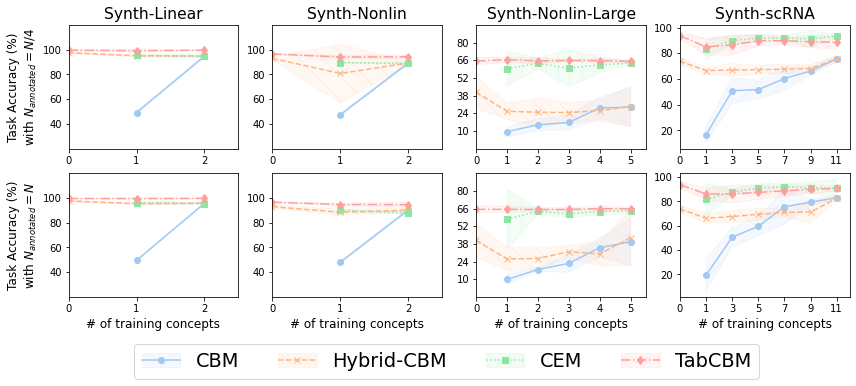

In [102]:
# Plot concept accuracies for all methods
# Set up our figure
p_annotations = [0.25, 1] #[0.25, 0.5, 0.75, 1]
color_map = {}
line_style_map = {}
marker_style_map = {}
hatch_style_map = {}
font = 15.5 #11
fig_width = 14 #10.5
fig_height = 2.5 * len(p_annotations) #1.6 * len(p_annotations)
fig, axs = plt.subplots(len(p_annotations), 4, figsize=(fig_width, fig_height))
metric = "acc"
handles = []
labels = []



for i, p_annotation in enumerate(p_annotations):
    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Linear" if i == 0 else "",
        ax=axs[i, 0],
        y_start=40, #96,
        y_end=100,
        y_delta=20, #0.5,
        y_label=(
            "Task Accuracy (%)\nwith $N_{{annotated}} = N/4$" if p_annotation == 0.25
            else "Task Accuracy (%)\nwith $N_{{annotated}} = N$"
        ),
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin" if i == 0 else "",
        ax=axs[i, 1],
        y_start=40, #96,
        y_end=100,
        y_delta=20, #0.5,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(0, 6),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin-Large" if i == 0 else "",
        ax=axs[i, 2],
        y_start=10,
        y_end=80,
        y_delta=14,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=[0, 1, 3, 5, 7, 9, 11],
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["single_cell"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-scRNA" if i == 0 else "",
        ax=axs[i, 3],
#         y_start=60,
#         y_end=100,
#         y_delta=5,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=font*1.25,
    loc='upper center',
    bbox_to_anchor=(0.5,0.02),
    ncol=4,
)

plt.savefig(
    os.path.join(
        "figures/",
        "concept_supervision_task_acc.png",
    ),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.savefig(
    os.path.join(
        "figures/",
        "concept_supervision_task_acc.pdf",
    ),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.show()

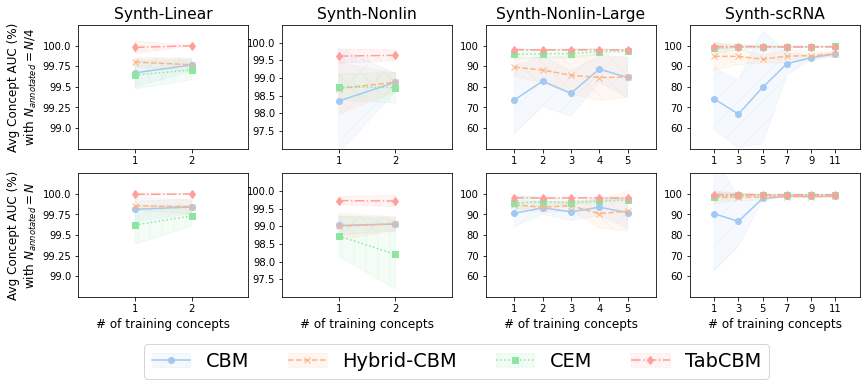

In [99]:
# Plot concept accuracies for all methods
# Set up our figure

p_annotations = [0.25, 1] #[0.25, 0.5, 0.75, 1]
color_map = {}
line_style_map = {}
marker_style_map = {}
hatch_style_map = {}
font = 15.5 #11
fig_width = 14 #10.5
fig_height = 2.5 * len(p_annotations) #1.6 * len(p_annotations)
fig, axs = plt.subplots(len(p_annotations), 4, figsize=(fig_width, fig_height))
metric = "avg_concept_auc"
handles = []
labels = []



for i, p_annotation in enumerate(p_annotations):
    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(1, 3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Linear" if i == 0 else "",
        ax=axs[i, 0],
        y_start=99,
        y_end=100,
        y_delta=0.25,
        y_label=(
            "Avg Concept AUC (%)\nwith $N_{{annotated}} = N/4$" if p_annotation == 0.25
            else "Avg Concept AUC (%)\nwith $N_{{annotated}} = N$"
        ),
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(1, 3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin" if i == 0 else "",
        ax=axs[i, 1],
        y_start=97.5,
        y_end=100,
        y_delta=0.5,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(1, 6),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin-Large" if i == 0 else "",
        ax=axs[i, 2],
        y_start=60,
        y_end=100,
        y_delta=10,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=[1, 3, 5, 7, 9, 11],
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-scRNA" if i == 0 else "",
        ax=axs[i, 3],
        y_start=60,
        y_end=100,
        y_delta=10,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=font*1.25,
    loc='upper center',
    bbox_to_anchor=(0.5,0.02),
    ncol=4,
)


plt.savefig(
    os.path.join(
        "figures/",
        "concept_supervision_avg_concept_auc.pdf",
    ),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.show()

# Average Metric Computation

In [96]:
metrics_to_use = [
    "cas",
    "sap",
    "mig",
    "r4",
    "dci_disentanglement",
    "dci_informativeness",
    "dci_completeness",
]

models_to_use = [
    "SENN",
    "CCD",
    "TabCBM",
    "PCA",
]
values = defaultdict(list)
rankings = defaultdict(lambda: defaultdict(list))

for dataset_name, ds_results in results.items():
#     if dataset_name != "single_cell":
#         continue
    tmp_rankings = defaultdict(list)
    for model_name in models_to_use:
        if (
            ((0, 0) not in ds_results[model_name])
        ):
            continue
        print(dataset_name, model_name)
        ds_and_model_results = ds_results[model_name][(0, 0)]
        for metric_name in metrics_to_use:
            if metric_name not in ds_and_model_results:
                print("Skipping for", model_name, metric_name)
                print(ds_and_model_results)
                continue
            values[(model_name, metric_name)].append(ds_and_model_results[metric_name][0])
            tmp_rankings[metric_name].append((model_name, ds_and_model_results[metric_name][0]))
    for metric_name, vals in tmp_rankings.items():
        ranks_in_ds = list(enumerate(map(
            lambda x: x[0],
            sorted(vals, key=lambda x: -x[1]),
        )))
        for rank, method_name in ranks_in_ds:
            print(dataset_name, metric_name, method_name, rank + 1)
            rankings[metric_name][method_name].append(rank + 1)
ranking_means = {}
print(rankings)
for metric_name, inner_ranks in rankings.items():
    for method_name, ranks in inner_ranks.items():
        ranking_means[(method_name, metric_name)] = (np.mean(ranks), np.std(ranks))

synth_linear SENN
synth_linear CCD
synth_linear TabCBM
synth_linear PCA
synth_linear cas TabCBM 1
synth_linear cas CCD 2
synth_linear cas SENN 3
synth_linear cas PCA 4
synth_linear sap TabCBM 1
synth_linear sap CCD 2
synth_linear sap SENN 3
synth_linear sap PCA 4
synth_linear mig TabCBM 1
synth_linear mig CCD 2
synth_linear mig SENN 3
synth_linear mig PCA 4
synth_linear r4 TabCBM 1
synth_linear r4 CCD 2
synth_linear r4 SENN 3
synth_linear r4 PCA 4
synth_linear dci_disentanglement TabCBM 1
synth_linear dci_disentanglement CCD 2
synth_linear dci_disentanglement PCA 3
synth_linear dci_disentanglement SENN 4
synth_linear dci_informativeness TabCBM 1
synth_linear dci_informativeness CCD 2
synth_linear dci_informativeness SENN 3
synth_linear dci_informativeness PCA 4
synth_linear dci_completeness TabCBM 1
synth_linear dci_completeness PCA 2
synth_linear dci_completeness CCD 3
synth_linear dci_completeness SENN 4
synth_nonlin SENN
synth_nonlin CCD
synth_nonlin TabCBM
synth_nonlin PCA
synth_no

In [97]:
for metric_name, (mean, std) in ranking_means.items():
    print(f"{metric_name} = {mean:.2f} $\pm$ {std:.2f}")

('TabCBM', 'cas') = 1.50 $\pm$ 0.87
('CCD', 'cas') = 3.00 $\pm$ 1.00
('SENN', 'cas') = 2.75 $\pm$ 0.43
('PCA', 'cas') = 2.75 $\pm$ 1.30
('TabCBM', 'sap') = 1.75 $\pm$ 0.83
('CCD', 'sap') = 1.75 $\pm$ 0.43
('SENN', 'sap') = 3.50 $\pm$ 0.50
('PCA', 'sap') = 3.00 $\pm$ 1.22
('TabCBM', 'mig') = 1.50 $\pm$ 0.87
('CCD', 'mig') = 2.00 $\pm$ 0.00
('SENN', 'mig') = 3.50 $\pm$ 0.50
('PCA', 'mig') = 3.00 $\pm$ 1.22
('TabCBM', 'r4') = 1.50 $\pm$ 0.87
('CCD', 'r4') = 2.00 $\pm$ 0.00
('SENN', 'r4') = 3.50 $\pm$ 0.50
('PCA', 'r4') = 3.00 $\pm$ 1.22
('TabCBM', 'dci_disentanglement') = 1.50 $\pm$ 0.87
('CCD', 'dci_disentanglement') = 2.00 $\pm$ 0.00
('PCA', 'dci_disentanglement') = 3.00 $\pm$ 1.22
('SENN', 'dci_disentanglement') = 3.50 $\pm$ 0.50
('TabCBM', 'dci_informativeness') = 1.75 $\pm$ 0.83
('CCD', 'dci_informativeness') = 2.25 $\pm$ 1.09
('SENN', 'dci_informativeness') = 3.00 $\pm$ 0.71
('PCA', 'dci_informativeness') = 3.00 $\pm$ 1.22
('TabCBM', 'dci_completeness') = 1.50 $\pm$ 0.87
('PCA', 'dc

In [ ]:
('PCA', 'cas') = 2.75 ± 1.299038105676658
('PCA', 'sap') = 3.0 ± 1.224744871391589
('PCA', 'mig') = 3.0 ± 1.224744871391589
('PCA', 'r4') = 3.0 ± 1.224744871391589
('PCA', 'dci_disentanglement') = 3.25 ± 0.82915619758885
('PCA', 'dci_informativeness') = 3.0 ± 1.224744871391589
('PCA', 'dci_completeness') = 2.5 ± 0.8660254037844386

In [98]:
for metric_name, vals in values.items():
    print(f"{metric_name} = {np.mean(vals)*100:.2f}\% $\pm$ {np.std(vals)*100:.2f}\%")

('SENN', 'cas') = 60.11\% $\pm$ 6.26\%
('SENN', 'sap') = 7.83\% $\pm$ 4.51\%
('SENN', 'mig') = 9.92\% $\pm$ 5.68\%
('SENN', 'r4') = 30.83\% $\pm$ 17.38\%
('SENN', 'dci_disentanglement') = 21.49\% $\pm$ 6.51\%
('SENN', 'dci_informativeness') = 32.50\% $\pm$ 25.82\%
('SENN', 'dci_completeness') = 29.56\% $\pm$ 7.30\%
('CCD', 'cas') = 52.86\% $\pm$ 20.82\%
('CCD', 'sap') = 22.22\% $\pm$ 10.52\%
('CCD', 'mig') = 29.57\% $\pm$ 5.86\%
('CCD', 'r4') = 65.79\% $\pm$ 10.49\%
('CCD', 'dci_disentanglement') = 39.66\% $\pm$ 5.89\%
('CCD', 'dci_informativeness') = 66.77\% $\pm$ 9.30\%
('CCD', 'dci_completeness') = 41.04\% $\pm$ 6.93\%
('TabCBM', 'cas') = 86.94\% $\pm$ 14.19\%
('TabCBM', 'sap') = 29.41\% $\pm$ 19.32\%
('TabCBM', 'mig') = 52.54\% $\pm$ 29.39\%
('TabCBM', 'r4') = 76.83\% $\pm$ 18.13\%
('TabCBM', 'dci_disentanglement') = 63.40\% $\pm$ 24.44\%
('TabCBM', 'dci_informativeness') = 74.73\% $\pm$ 19.45\%
('TabCBM', 'dci_completeness') = 69.59\% $\pm$ 22.53\%
('PCA', 'cas') = 57.54\% $\pm$ 1

In [ ]:
('SENN', 'cas') = 0.5853859677728546 ± 0.052341903584385986
('SENN', 'sap') = 0.06898112032207347 ± 0.042201199669282326
('SENN', 'mig') = 0.08338925230112695 ± 0.04909670235293051
('SENN', 'r4') = 0.27157145593433274 ± 0.14767896629888483
('SENN', 'dci_disentanglement') = 0.18793077974597644 ± 0.025274463477735903
('SENN', 'dci_informativeness') = 0.2800835500415345 ± 0.23548491398279325
('SENN', 'dci_completeness') = 0.26644223462311595 ± 0.04763861195145491
('CCD', 'cas') = 0.515179746349623 ± 0.19518833559295262
('CCD', 'sap') = 0.22802977351342998 ± 0.1013711117668626
('CCD', 'mig') = 0.30929852235860134 ± 0.055038346847259785
('CCD', 'r4') = 0.6638285290609774 ± 0.09899761498733257
('CCD', 'dci_disentanglement') = 0.4100268241218665 ± 0.0629522803014697
('CCD', 'dci_informativeness') = 0.6614810186044311 ± 0.10038673827823773
('CCD', 'dci_completeness') = 0.4182460337974754 ± 0.07164919012317784
('TabCBM', 'cas') = 0.9036325435466036 ± 0.11723060692416225
('TabCBM', 'sap') = 0.34786729973890973 ± 0.15568562621247845
('TabCBM', 'mig') = 0.6446531715237405 ± 0.1947070200251306
('TabCBM', 'r4') = 0.8321975492776252 ± 0.12202572837881434
('TabCBM', 'dci_disentanglement') = 0.7941056391275794 ± 0.16414631118565692
('TabCBM', 'dci_informativeness') = 0.8090893421160049 ± 0.11173058556534254
('TabCBM', 'dci_completeness') = 0.800969167810019 ± 0.15316114939401565
('PCA', 'cas') = 0.5754173618193414 ± 0.12890763577526002
('PCA', 'sap') = 0.045347695516735884 ± 0.051527699421128434
('PCA', 'mig') = 0.09477690501272674 ± 0.1573212596930208
('PCA', 'r4') = 0.19592181848703216 ± 0.2818197537312243
('PCA', 'dci_disentanglement') = 0.24152293503712752 ± 0.1689749446637033
('PCA', 'dci_informativeness') = 0.18697704717699654 ± 0.32682881886126564
('PCA', 'dci_completeness') = 0.3617033224416536 ± 0.15859554324888775

# Mask Analysis

In [ ]:
trial = 0
experiment_config = joblib.load('results/fico_no_embs/TabCBM/config_smaller_k_4_latent_64_weight1_0.1_weight2_5_trial_0.joblib')
cat_features_fn = None
if experiment_config.get('use_cat_embs', False):
    cat_features_fn = datasets.fico_cat_feats
data_generator = datasets.generate_fico_data 

data = data_generator(
    seed=trial,
    **experiment_config.get('data_hyperparams', {}),
)
if len(data) == 2 and isinstance(data[0], (tuple, list)) and isinstance(
    data[1],
    (dict,)
):
    data, extra_hypers = data
if len(data) == 7:
    x_train, x_test, y_train, y_test, c_train, c_test, ground_truth_concept_masks = data
elif len(data) == 6:
    x_train, x_test, y_train, y_test, c_train, c_test = data
    ground_truth_concept_masks = None
elif len(data) == 4:
    x_train, x_test, y_train, y_test = data
    c_train = c_test = None
    ground_truth_concept_masks = None
else:
    raise ValueError(
        'Expected data generator to output tuple (x_train, x_test, y_train, y_test, c_train, c_test), '
        'tuple (x_train, x_test, y_train, y_test), or tuple '
        '(x_train, x_test, y_train, y_test, c_train, c_test, ground_truth_concept_masks). '
        f'Instead we got a tuple with {len(data)} elements in it.'
    )

if cat_features_fn is not None:
    cat_feat_inds, cat_dims = cat_features_fn(
        **experiment_config.get('data_hyperparams', {})
    )
else:
    cat_feat_inds, cat_dims = None, None

extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
if extra_name:
    extra_name = "_" + extra_name
extra_name = extra_name + f"_trial_{trial}"

model = train_tabcbm.load_tabcbm(
    x_train=x_train.astype(np.float32),
    experiment_config=experiment_config,
    extra_name=extra_name,
    cat_feat_inds=cat_feat_inds,
    cat_dims=cat_dims,
        
)

In [ ]:
import tensorflow as tf
print(tf.sigmoid(model.feature_probabilities.numpy()).numpy())
lbls, concepts = model(x_test.astype(np.float32))
lbls = (tf.sigmoid(lbls) >= 0.5).numpy().astype(np.int32)
concepts = concepts.numpy()
print("lbls =", lbls)
print("y =", y_test)
print("concepts =", concepts)
print("acc =", np.mean(lbls == y_test))

In [ ]:
names = [
    "ExternalRiskEstimate",
    "MSinceOldestTradeOpen",
    "MSinceMostRecentTradeOpen",
    "AverageMInFile",
    "NumSatisfactoryTrades",
    "NumTrades60Ever2DerogPubRec",
    "NumTrades90Ever2DerogPubRec",
    "NumTotalTrades",
    "NumTradesOpeninLast12M",
    "PercentTradesNeverDelq",
    "MSinceMostRecentDelq",
    "MaxDelq2PublicRecLast12M",
    "MaxDelqEver",
    "PercentInstallTrades",
    "NetFractionInstallBurden",
    "NumInstallTradesWBalance",
    "MSinceMostRecentInqexcl7days",
    "NumInqLast6M",
    "NumInqLast6Mexcl7days",
    "NetFractionRevolvingBurden",
    "NumRevolvingTradesWBalance",
    "NumBank2NatlTradesWHighUtilization",
    "PercentTradesWBalance"
]
for i in range(5):
    mask = np.load(f'results/fico/TabCBM/end_feature_mask_smaller_k_8_latent_64_weight1_0.01_weight2_1_trial_{i}.npy')
    print("Max:", np.max(mask))
    print("Min:", np.min(mask))
    for j, m in enumerate(mask):
#         print(m)
        m = (m > 0.5).astype(np.int32)
#         print(m)
        l = []
        for bit, name in zip(m, names):
            if bit == 1:
                l.append(name)
        print(f"Concept #{j}:", ", ".join(l))
    print()

# Single-Cell Qualitative Analysis

[WARNING] Assuming independence between features in TabCBM training.
Trial 1


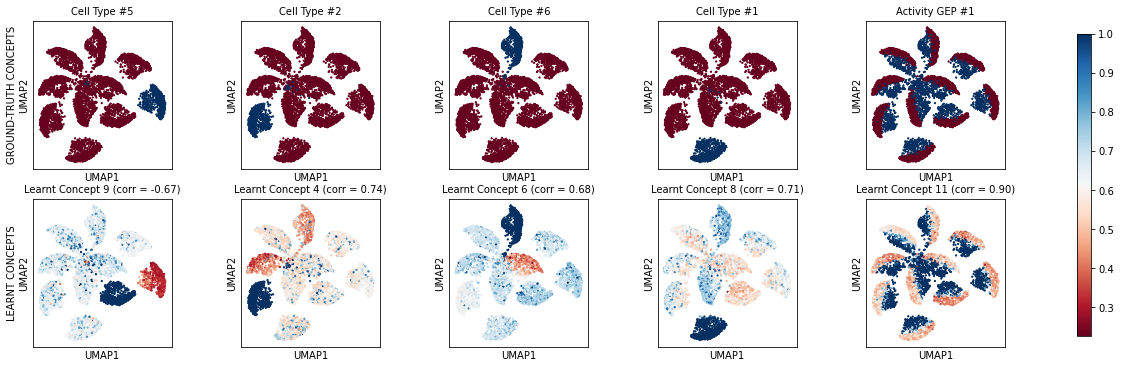




 **************************************** 



[WARNING] Assuming independence between features in TabCBM training.
Trial 2


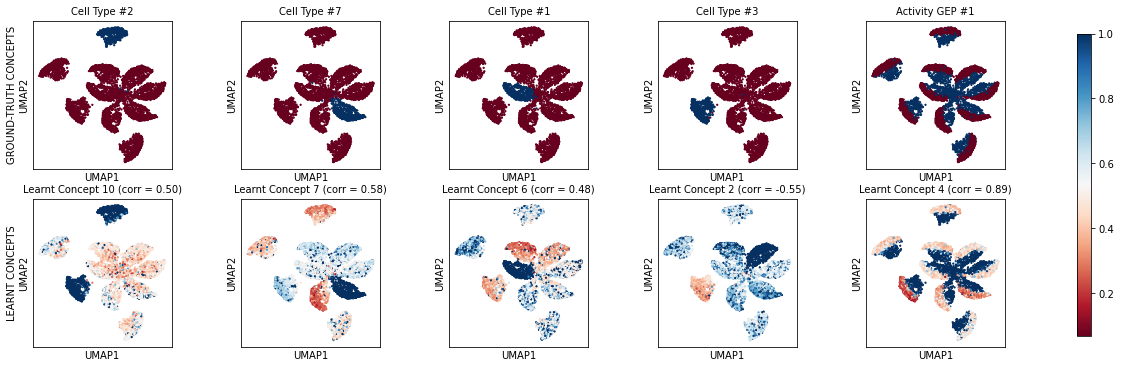




 **************************************** 



[WARNING] Assuming independence between features in TabCBM training.
Trial 3


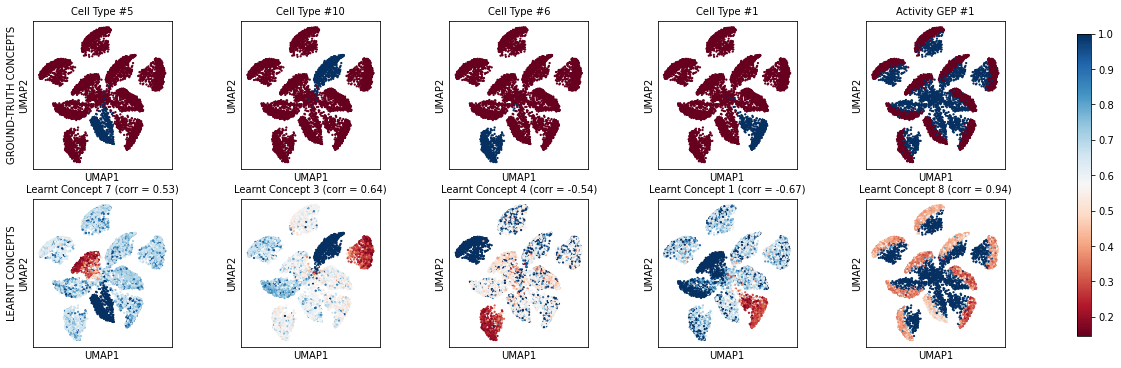




 **************************************** 



[WARNING] Assuming independence between features in TabCBM training.
Trial 4


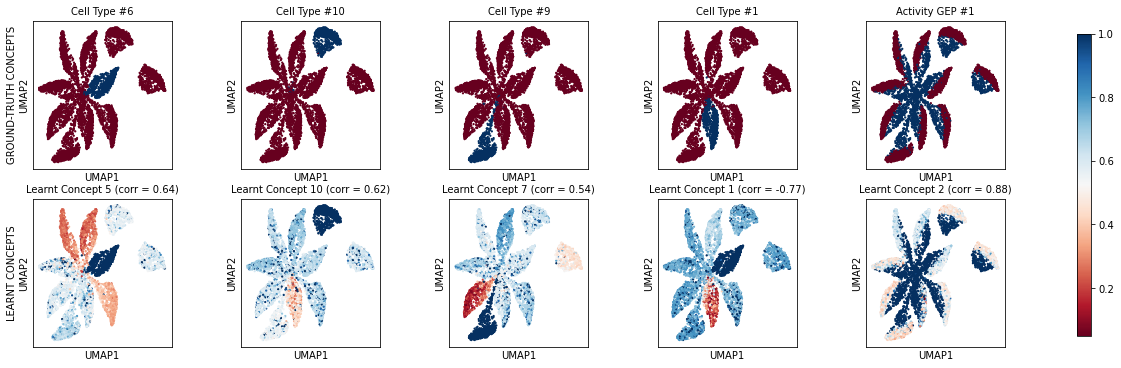




 **************************************** 



[WARNING] Assuming independence between features in TabCBM training.
Trial 5


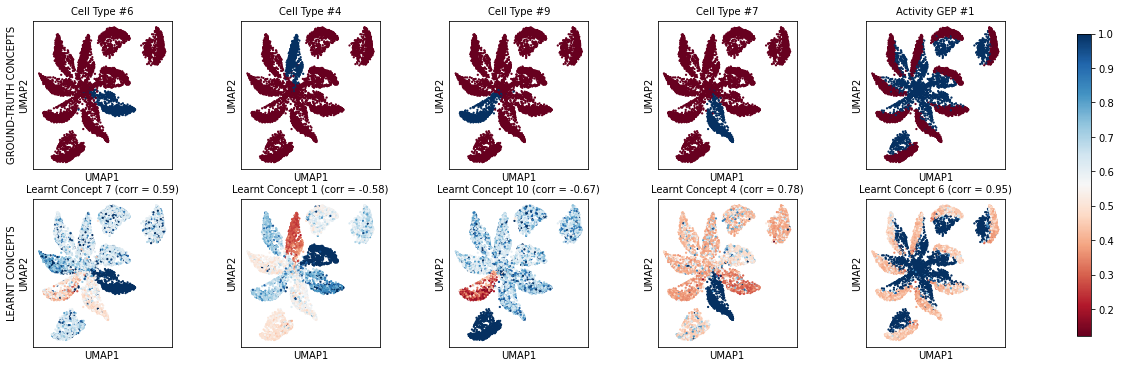




 **************************************** 





In [27]:
import yaml
import tensorflow as tf

with open('/homes/me466/tmp_tabcbm_results/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)
    
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    experiment_config = joblib.load(f'/homes/me466/tmp_tabcbm_results/sc_synth/sc_10_cell_types/TabCBM/config_k_11_bn_True_partience_750_epochs_3000_trial_{trial}.joblib')
    extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
    if extra_name:
        extra_name = "_" + extra_name
    extra_name = extra_name + f"_trial_{trial}"

    model = train_tabcbm.load_tabcbm(
        x_train=X_train.astype(np.float32),
        experiment_config=experiment_config,
        extra_name=extra_name,
    )
    preds, concept_scores = model.predict(adata.X)
    
    sample_projections = adata.obsm['X_umap']
    
    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    corr_mat = np.corrcoef(np.hstack([concept_scores, concepts]).T)[:n_concepts, n_concepts:]
    print("Trial", trial + 1)
#     for selected_concept in range(n_concepts):
#         fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height))
#         axs[0].scatter(
#             sample_projections[:, 0],
#             sample_projections[:, 1],
#             marker='.',
#             c=concepts[:, selected_concept],
#             s=dot_size,
#             cmap=plt.cm.get_cmap(colormap),
#         )
#         axs[0].set_xticks([])
#         axs[0].set_yticks([])
#         axs[0].set_xlabel("UMAP1", fontsize=font)
#         axs[0].set_ylabel("UMAP2", fontsize=font)
#         axs[0].set_title(
# #             f"Ground-Truth Concept {selected_concept + 1}"
#             f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
#             fontsize=font,
#         )
#         axs[0].grid(False)



#         matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
#         activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
#         thresh = np.percentile(activated_learnt_concepts, 90)
#         activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
#         out = axs[1].scatter(
#             sample_projections[:, 0],
#             sample_projections[:, 1],
#             marker='.',
#             c=concept_scores[:, matched_learnt_concept], #'black',
#             s=dot_size,
#             cmap=plt.cm.get_cmap(colormap),
#         )
#         fig.colorbar(out)

#         axs[1].set_xticks([])
#         axs[1].set_yticks([])
#         axs[1].set_xlabel("UMAP1", fontsize=font)
#         axs[1].set_ylabel("UMAP2", fontsize=font)
#         axs[1].set_title(
#             f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
#             fontsize=font,
#         )
#         axs[1].grid(False)
#         fig.suptitle("")
        
#         # And save the figure
#         plt.savefig(
#             os.path.join(
#                 "figures/",
#                 f"sc_concept_{selected_concept}_best_match_plot_trial_{trial}.png",
#             ),
#             bbox_inches='tight'
#         )
#         plt.savefig(
#             os.path.join(
#                 "figures/",
#                 f"sc_concept_{selected_concept}_best_match_plot_trial_{trial}.pdf",
#             ),
#             bbox_inches='tight'
#         )
#         plt.show()
    n_shown = 5
    fig, axs = plt.subplots(2, n_shown, figsize=(20, 6))
    for i, selected_concept in enumerate(list(np.random.permutation(n_concepts - 1))[:n_shown-1] + [10]):
        axs[0, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        axs[0, i].set_xlabel("UMAP1", fontsize=font)
        if i == 0:
            axs[0, i].set_ylabel("GROUND-TRUTH CONCEPTS\nUMAP2", fontsize=font)
        else:
            axs[0, i].set_ylabel("UMAP2", fontsize=font)
        axs[0, i].set_title(
#             f"Ground-Truth Concept {selected_concept + 1}"
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        axs[0, i].grid(False)



        matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
        activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
        thresh = np.percentile(activated_learnt_concepts, 90)
        activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
        out = axs[1, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concept_scores[:, matched_learnt_concept], #'black',
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )

        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        axs[1, i].set_xlabel("UMAP1", fontsize=font)
        if i == 0:
            axs[1, i].set_ylabel("LEARNT CONCEPTS\nUMAP2", fontsize=font)
        else:
            axs[1, i].set_ylabel("UMAP2", fontsize=font)
        axs[1, i].set_title(
            f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
            fontsize=font,
        )
        axs[1, i].grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.5)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_trial_{trial}_2.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_trial_{trial}_2.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")
    
    

Trial 1


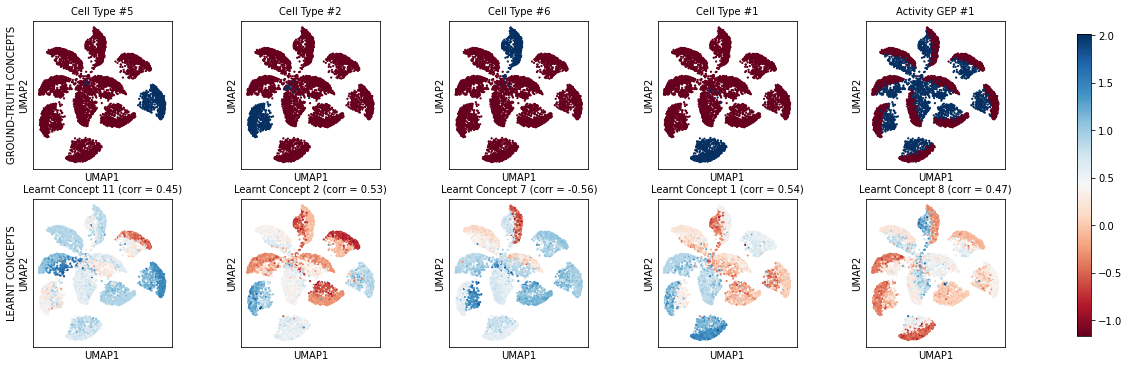




 **************************************** 





Trial 2


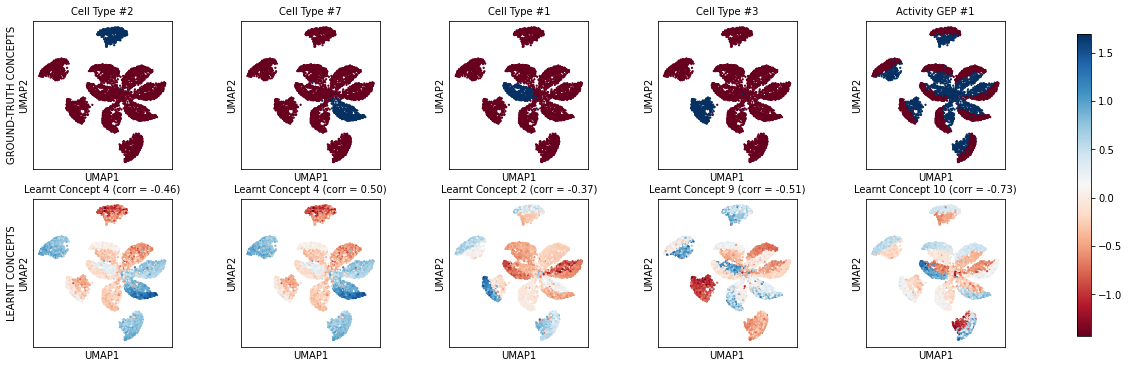




 **************************************** 





Trial 3


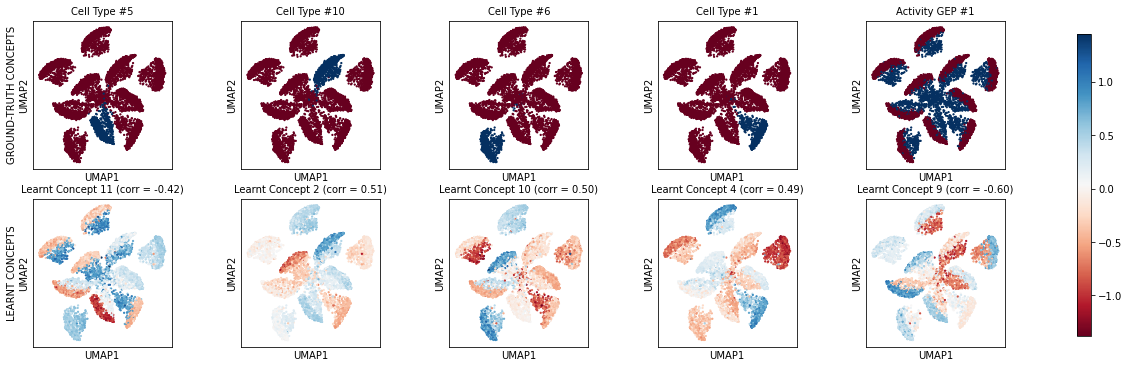




 **************************************** 





Trial 4


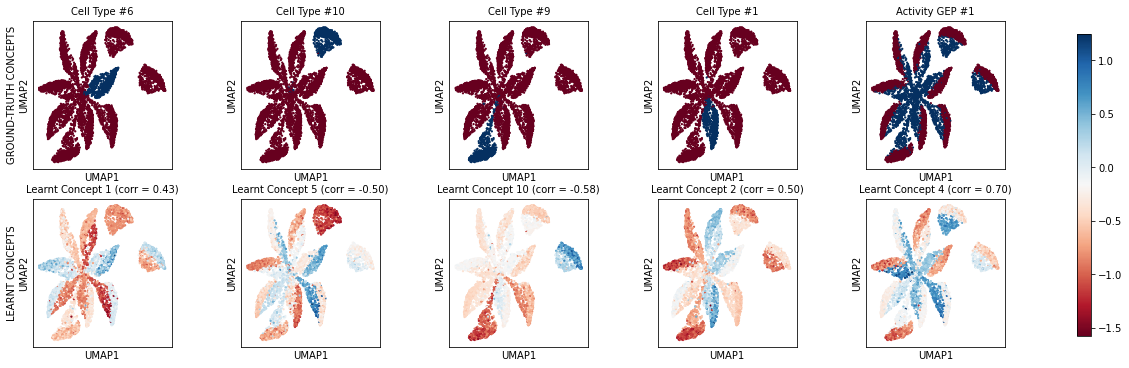




 **************************************** 





Trial 5


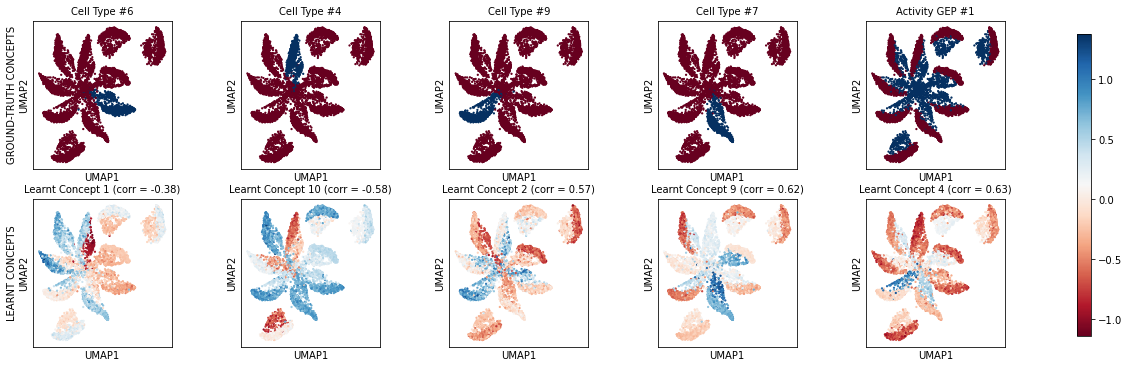




 **************************************** 





In [28]:
import yaml
import training.train_senn
import tensorflow as tf
import models.models as models

with open(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)
    
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    experiment_config = joblib.load(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/SENN/config_k_11_trial_{trial}.joblib')
    extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
    if extra_name:
        extra_name = "_" + extra_name
    extra_name = extra_name + f"_trial_{trial}"
        
    encoder_path = os.path.join(
        experiment_config["results_dir"],
        f"models/encoder{extra_name}"
    )
    concept_encoder = tf.keras.models.load_model(encoder_path)
    concept_decoder = tf.keras.models.load_model(
        encoder_path.replace('/encoder_', '/decoder_')
    )
    coefficient_model = tf.keras.models.load_model(
        encoder_path.replace('/encoder_', '/coefficient_model_')
    )
    model = models.construct_senn_model(
        concept_encoder=concept_encoder,
        concept_decoder=concept_decoder,
        coefficient_model=coefficient_model,
        num_outputs=max(experiment_config["num_outputs"], 2),
        regularization_strength=experiment_config.get(
            "regularization_strength",
            0.1,
        ),
        learning_rate=experiment_config.get("learning_rate", 1e-3),
        sparsity_strength=experiment_config.get(
            "sparsity_strength",
            2e-5,
        ),
    )
    preds, (_, x_test_theta_class_scores) = model.predict(
        adata.X,
        batch_size=experiment_config["batch_size"],
    )
    concept_scores = training.train_senn.get_argmax_concept_explanations(
        preds,
        x_test_theta_class_scores,
    )
    
    sample_projections = adata.obsm['X_umap']
    
    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    corr_mat = np.corrcoef(np.hstack([concept_scores, concepts]).T)[:n_concepts, n_concepts:]
    print("Trial", trial + 1)
    n_shown = 5
    fig, axs = plt.subplots(2, n_shown, figsize=(20, 6))
    for i, selected_concept in enumerate(list(np.random.permutation(n_concepts - 1))[:n_shown-1] + [10]):
        axs[0, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        axs[0, i].set_xlabel("UMAP1", fontsize=font)
        if i == 0:
            axs[0, i].set_ylabel("GROUND-TRUTH CONCEPTS\nUMAP2", fontsize=font)
        else:
            axs[0, i].set_ylabel("UMAP2", fontsize=font)
        axs[0, i].set_title(
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        axs[0, i].grid(False)



        matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
        activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
        thresh = np.percentile(activated_learnt_concepts, 90)
        activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
        out = axs[1, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concept_scores[:, matched_learnt_concept], #'black',
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )

        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        axs[1, i].set_xlabel("UMAP1", fontsize=font)
        if i == 0:
            axs[1, i].set_ylabel("LEARNT CONCEPTS\nUMAP2", fontsize=font)
        else:
            axs[1, i].set_ylabel("UMAP2", fontsize=font)
        axs[1, i].set_title(
            f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
            fontsize=font,
        )
        axs[1, i].grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.5)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_senn_trial_{trial}_2.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_senn_trial_{trial}_2.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")
    
    

Trial 1


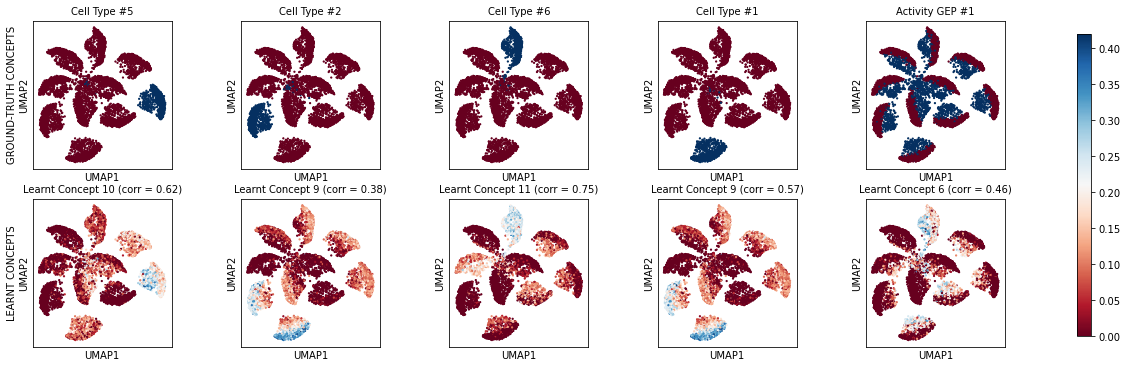




 **************************************** 





Trial 2


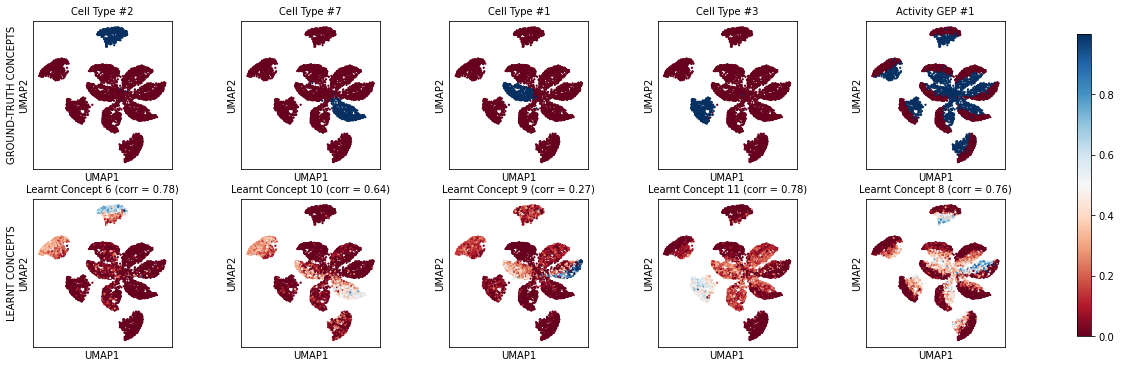




 **************************************** 





Trial 3


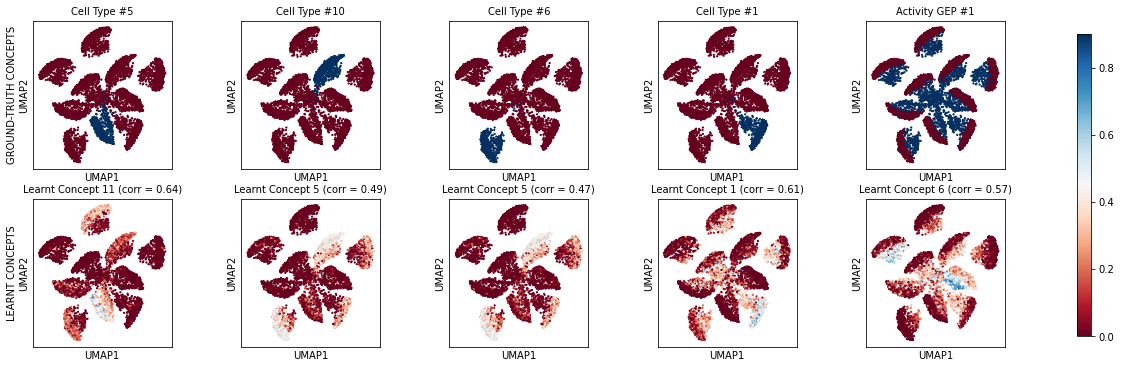




 **************************************** 





Trial 4


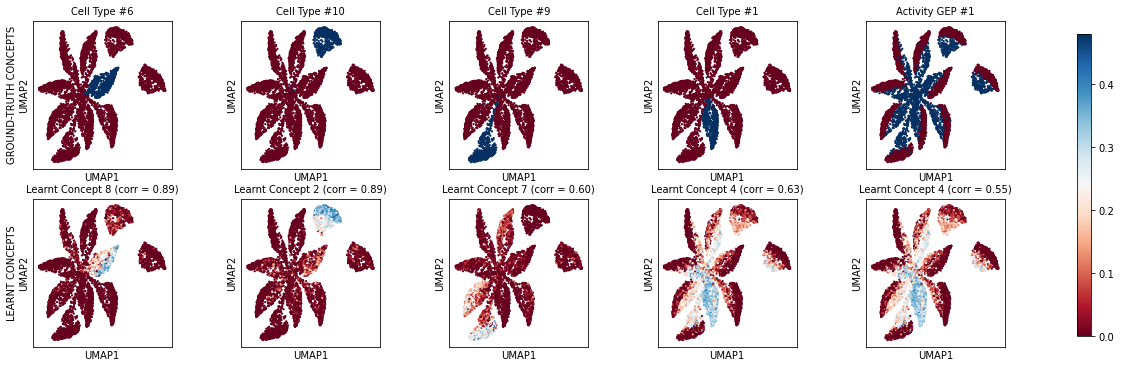




 **************************************** 





Trial 5


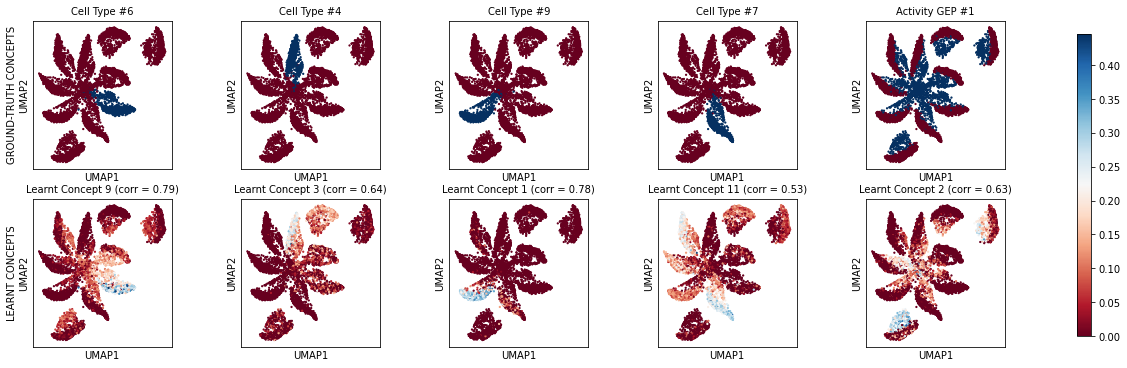




 **************************************** 





In [29]:
import yaml
import concepts_xai.methods.OCACE.topicModel as CCD
import tensorflow as tf
import models.models as models

with open(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)
    
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    experiment_config = joblib.load(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/CCD/config_k_11_trial_{trial}.joblib')
    extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
    if extra_name:
        extra_name = "_" + extra_name
    extra_name = extra_name + f"_trial_{trial}"
    
    
    encoder_path = os.path.join(
        experiment_config["results_dir"],
        f"models/encoder{extra_name}"
    )
    decoder_path = os.path.join(
        experiment_config["results_dir"],
        f"models/decoder{extra_name}"
    )
    encoder = tf.keras.models.load_model(encoder_path)
    decoder = tf.keras.models.load_model(decoder_path)
    end_to_end_model, encoder, decoder = models.construct_end_to_end_model(
        input_shape=experiment_config["input_shape"],
        num_outputs=experiment_config["num_outputs"],
        learning_rate=experiment_config["learning_rate"],
        encoder=encoder,
        decoder=decoder,
    )
    def derp(y_true, y_pred):
        return tf.keras.metrics.binary_accuracy(
            tf.cast(y_true, tf.int32),
            tf.cast(tf.math.sigmoid(y_pred) >= 0.5, tf.int32)
        )
    topic_model = CCD.TopicModel(
        concepts_to_labels_model=decoder,
        n_channels=experiment_config["latent_dims"],
        n_concepts=experiment_config['n_concepts'],
        threshold=experiment_config.get("threshold", 0.5),
        loss_fn=end_to_end_model.loss,
        top_k=experiment_config.get("top_k", 32),
        lambda1=experiment_config.get("lambda1", 0.1),
        lambda2=experiment_config.get("lambda2", 0.1),
        seed=42,
        eps=experiment_config.get("eps", 1e-5),
        data_format=experiment_config.get(
            "data_format",
            "channels_last"
        ),
        allow_gradient_flow_to_c2l=experiment_config.get(
            'allow_gradient_flow_to_c2l',
            False,
        ),
        acc_metric=(
            (
                lambda y_true, y_pred: tf.keras.metrics.sparse_categorical_accuracy(
                    y_true,
                    y_pred,
                )
            ) if experiment_config["num_outputs"] > 1 else derp
        ),
    )
    topic_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            experiment_config.get("learning_rate", 1e-3),
        )
    )
    
    ccd_g_model_path = os.path.join(
        experiment_config["results_dir"],
        f"models/ccd_g_model{extra_name}"
    )
    topic_model.g_model = tf.keras.models.load_model(ccd_g_model_path)
    topic_model.topic_vector.assign(np.load(
        ccd_g_model_path.replace('g_model', 'topic_vector_n') + ".npy"
    ))
        
    test_encodings = encoder.predict(
        adata.X,
        batch_size=experiment_config["batch_size"],
    )
    preds, concept_scores = topic_model.predict(
        test_encodings,
        batch_size=experiment_config["batch_size"],
    )
    
    sample_projections = adata.obsm['X_umap']
    
    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    corr_mat = np.corrcoef(np.hstack([concept_scores, concepts]).T)[:n_concepts, n_concepts:]
    print("Trial", trial + 1)
    n_shown = 5
    fig, axs = plt.subplots(2, n_shown, figsize=(20, 6))
    for i, selected_concept in enumerate(list(np.random.permutation(n_concepts - 1))[:n_shown-1] + [10]):
        axs[0, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        axs[0, i].set_xlabel("UMAP1", fontsize=font)
        if i == 0:
            axs[0, i].set_ylabel("GROUND-TRUTH CONCEPTS\nUMAP2", fontsize=font)
        else:
            axs[0, i].set_ylabel("UMAP2", fontsize=font)
        axs[0, i].set_title(
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        axs[0, i].grid(False)



        matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
        activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
        thresh = np.percentile(activated_learnt_concepts, 90)
        activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
        out = axs[1, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concept_scores[:, matched_learnt_concept], #'black',
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )

        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        axs[1, i].set_xlabel("UMAP1", fontsize=font)
        if i == 0:
            axs[1, i].set_ylabel("LEARNT CONCEPTS\nUMAP2", fontsize=font)
        else:
            axs[1, i].set_ylabel("UMAP2", fontsize=font)
        axs[1, i].set_title(
            f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
            fontsize=font,
        )
        axs[1, i].grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.5)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_ccd_trial_{trial}.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_ccd_trial_{trial}.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")
    
    

# scRNA Dataset Visualization

In [ ]:
import yaml
import concepts_xai.methods.OCACE.topicModel as CCD
import tensorflow as tf
import models.models as models

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)

with open(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    sample_projections = adata.obsm['X_umap']

    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    print("Trial", trial + 1)
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(2, (n_concepts - 1)//2 + 2)
    for selected_concept in range(n_concepts):
        n_cols = (n_concepts - 1)//2
        row = selected_concept // n_cols
        col = selected_concept % n_cols
        if selected_concept < n_concepts - 1:
            ax = fig.add_subplot(gs[row, col])
        else:
            ax = fig.add_subplot(gs[:, -2:])
        ax.scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        ax.set_xticks([])
        ax.set_yticks([])
        if selected_concept != n_concepts - 1:
            if col == 0:
                ax.set_ylabel("UMAP2", fontsize=font)
            if row == 1:
                ax.set_xlabel("UMAP1", fontsize=font)
        else:
            ax.set_xlabel("UMAP1", fontsize=font)
            ax.set_ylabel("UMAP2", fontsize=font)
        ax.set_title(
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        ax.grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.2)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
#     fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_cell_types_trial_{trial}.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_cell_types_trial_{trial}.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")

# Interventions

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.7 frac_data = 1 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1 2] y_means = [93.66460675 95.49568914 97.38472127] y_stds = [1.40536995 3.47944504 0.        ]
best_ind_alignment_auc = (0.7550023154949678, 0.24126027621975163)
thresh = 0.7 frac_data = 1 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6 7] y_means = [87.40135492 93.38254332 96.35734206 97.91100575 97.92195716 97.92195716
 98.59951135 98.96765313] y_stds = [2.90902825 3.03667328 3.0843056  1.09010419 1.09903438 1.09903438
 0.43117244 0.        ]
best_ind_alignment_auc = (0.983000872291627, 0.012111545384610919)
thresh = 0.7 frac_data = 1 ds_name = single_cell percent = 1 model_name = TabCBM x_vals = [ 0  1  2  3  4  5  6  7  8  9 10 11] y_means = [ 90.63910753  93.33342184  97.84312553  99.71842661  99.92824786
 100.         100.         100.         100.         100.
 100.         100.        ] 

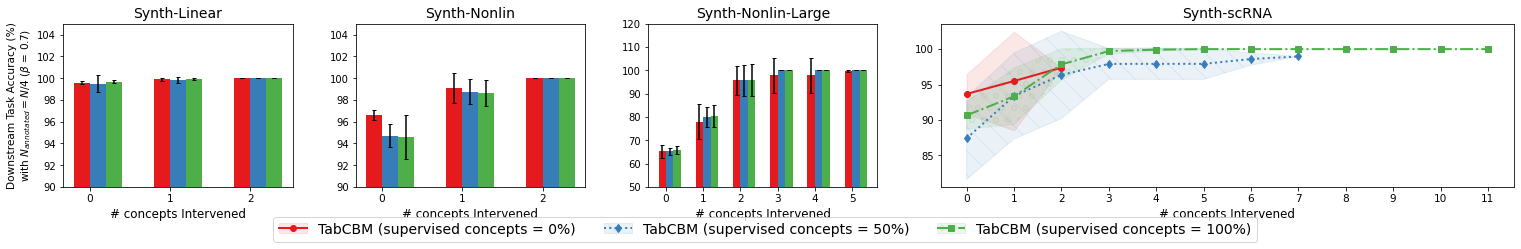

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.75 frac_data = 1 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1] y_means = [93.66460675 95.86182816] y_stds = [1.40536995 3.63866214]
best_ind_alignment_auc = (0.7550023154949678, 0.24126027621975163)
thresh = 0.75 frac_data = 1 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6 7] y_means = [87.40135492 93.56671607 97.19826107 97.88046338 97.88046338 97.88046338
 98.90203327 98.96765313] y_stds = [2.90902825 2.59908762 1.02053871 1.09942987 1.09942987 1.09942987
 0.06561986 0.        ]
best_ind_alignment_auc = (0.983000872291627, 0.012111545384610919)
thresh = 0.75 frac_data = 1 ds_name = single_cell percent = 1 model_name = TabCBM x_vals = [ 0  1  2  3  4  5  6  7  8  9 10 11] y_means = [ 90.63910753  92.64455425  95.88599924  98.56632558  99.99449415
 100.         100.         100.         100.         100.
 100.         100.        ] y_stds = [0.97651427 2

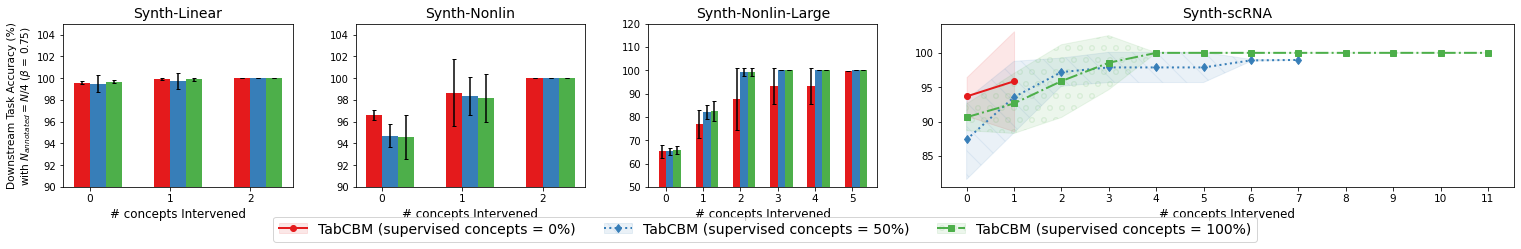

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.8 frac_data = 1 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1] y_means = [93.66460675 97.63358226] y_stds = [1.40536995 0.92426446]
best_ind_alignment_auc = (0.7550023154949678, 0.24126027621975163)
thresh = 0.8 frac_data = 1 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6 7] y_means = [87.40135492 89.27211341 92.81774181 97.88046338 97.88046338 97.88046338
 98.90203327 98.96765313] y_stds = [2.90902825 3.74565263 4.13917471 1.09942987 1.09942987 1.09942987
 0.06561986 0.        ]
best_ind_alignment_auc = (0.983000872291627, 0.012111545384610919)
thresh = 0.8 frac_data = 1 ds_name = single_cell percent = 1 model_name = TabCBM x_vals = [ 0  1  2  3  4  5  6  7  8  9 10 11] y_means = [ 90.63910753  92.55731699  97.99621301  99.34070582  99.95865422
 100.         100.         100.         100.         100.
 100.         100.        ] y_stds = [0.97651427 1.25

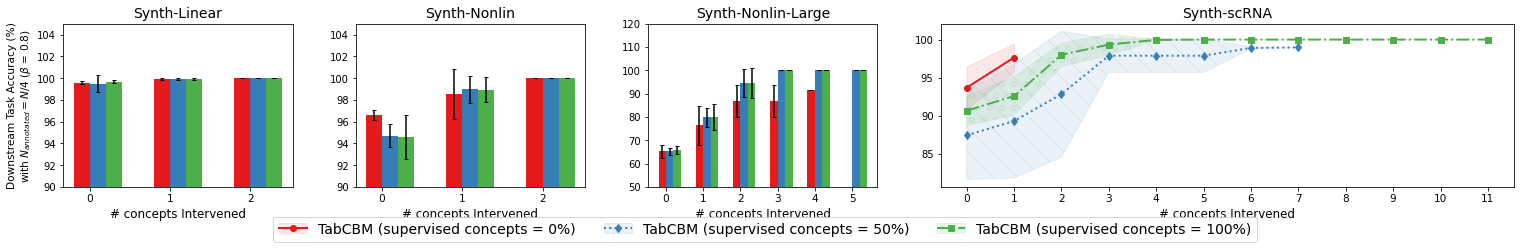

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.85 frac_data = 1 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1] y_means = [93.66460675 97.63358226] y_stds = [1.40536995 0.92426446]
best_ind_alignment_auc = (0.7550023154949678, 0.24126027621975163)
thresh = 0.85 frac_data = 1 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6] y_means = [87.40135492 88.57699453 94.67587463 97.79817711 97.85293413 97.85293413
 98.83321015] y_stds = [2.90902825e+00 3.25535478e+00 4.53936962e+00 1.02771932e+00
 1.07327464e+00 1.07327464e+00 3.20326658e-03]
best_ind_alignment_auc = (0.983000872291627, 0.012111545384610919)
thresh = 0.85 frac_data = 1 ds_name = single_cell percent = 1 model_name = TabCBM x_vals = [ 0  1  2  3  4  5  6  7  8  9 10 11] y_means = [ 90.63910753  92.42998956  95.78756625  99.55766458  99.95618062
  99.99179207 100.         100.         100.         100.
 100.         100.        ] y_stds = [0.9765142

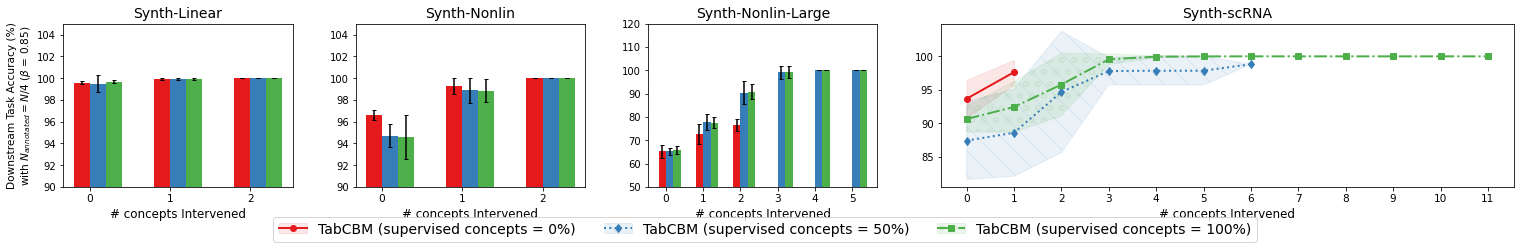

In [16]:
ds_names = [
    ('single_cell', 'Synth-scRNA', 11),
    ('synth_nonlin_complex', 'Synth-Nonlin-Large', 5),
    ('synth_nonlin', 'Synth-Nonlin', 2),
    ('synth_linear', 'Synth-Linear', 2),
]
percent_styles = [
    (0, 'solid', 'o', None),
#     (0.25, 'dashed', 'x', '/'),
    (0.5, 'dotted', 'd', '\\'),
#     (0.75, 'dashdot', 's', 'o'),
    (1, 'dashdot', 's', 'o'),
]
model_names = [
      'TabCBM',
]
metric_fn = lambda concept_ints, thresh: f'acc_intervention_{concept_ints}_thresh_{thresh}'
frac_data_list = [1] #[0.25, 1]
threshs = [0.7, 0.75, 0.8, 0.85] #[0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75,0.8, 0.85]
for thresh in threshs:
    labels = []
    handles = []
    alpha = 0.1
    font = 14
    bar_width = 0.2
    color_map = {}
    clrs = sns.color_palette("Set1", 10)
    fig, axs = plt.subplots(
        len(frac_data_list),
        len(ds_names),
        figsize=(26, 3*len(frac_data_list)),
        gridspec_kw={'width_ratios': [1, 1, 1, 2.5]},
        squeeze=False,
    )
    
    for frac_idx, frac_data in enumerate(frac_data_list):
        for ds_idx, (ds_name, ds_pretty_name, n_concepts) in enumerate(ds_names):
            ax = axs[frac_idx, len(ds_names) - ds_idx - 1]
            for model_name in model_names:
                seen = set()
                for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                    percent_styles
                ):
                    sup_concepts = int(np.floor(n_concepts * percent))
                    og_frac_data = frac_data
                    curr_metrics = results[ds_name][model_name]
                    if frac_data == 0 or percent == 0:
                        # Then because supervision is not provided, we will
                        # simply always use the 0% supervised dataset for consistency
                        curr_metrics = curr_metrics[(0, 0)]
                    elif (sup_concepts, frac_data) in curr_metrics:
                        curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                    elif (sup_concepts + 1, frac_data) in curr_metrics:
                        curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                    elif (sup_concepts - 1, frac_data) in curr_metrics:
                        curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                    else:
                        continue
                    key = (model_name, percent)
                    if key not in color_map:
                        color_map[key] = clrs[len(color_map)]
                    color = color_map[key]
                    y_means = []
                    y_stds = []
                    x_vals = []
                    print('best_ind_alignment_auc =', curr_metrics['best_ind_alignment_auc'])
                    for concept_ints in range(n_concepts + 1):
                        if concept_ints == 0:
                            mean, std = curr_metrics['acc']
                        elif metric_fn(concept_ints, thresh) in curr_metrics:
                            mean, std = curr_metrics[metric_fn(concept_ints, thresh)]
                        else:
                            continue
                        y_means.append(mean)
                        y_stds.append(std)
                        x_vals.append(concept_ints)
                    x_vals = np.array(x_vals)
                    y_means = 100 * np.array(y_means)
                    y_stds = 100 * np.array(y_stds)
                    print("thresh =", thresh, "frac_data =", frac_data, "ds_name =", ds_name, "percent =", percent, "model_name =", model_name, "x_vals =", x_vals, "y_means =", y_means, "y_stds =", y_stds)
                    if n_concepts > 5:
                        p1 = ax.plot(
                            x_vals,
                            y_means,
                            color=color,
                            linestyle=line_style,
                            linewidth=2,
                            marker=mark_style,
                        )
                        ax.fill_between(
                            x_vals,
                            y_means - 2*y_stds,
                            y_means + 2*y_stds,
                            color=color,
                            alpha=alpha,
                            hatch=hatch_style,
                        )
                    else:
                        p1 = ax.bar(
                            x=x_vals + idx * bar_width,
                            height=y_means,
                            width=bar_width,
                            align='edge',
                            color=color,
                            linewidth=2,
                            capsize=2,
                            yerr=2*y_stds,
                        )
                        if n_concepts == 2:
                            ax.set_ylim((90, 105)) #(65, 120))
                        elif n_concepts == 5:
                            ax.set_ylim((50, 120)) #((75, 110))
                        else:
                            ax.set_ylim((80, 105)) #((75, 110))
                    if frac_idx == 0:
                        ax.set_title(ds_pretty_name, fontsize=font)
                    if frac_idx == len(frac_data_list) - 1:
                        ax.set_xlabel('# concepts Intervened', fontsize=(0.85 * font))
                    if n_concepts > 5:
                        ax.set_xticks(
                            x_vals,
                            [f'{int(j)}' for j in x_vals], fontsize=(0.75 * font)
                        )
                    else:
                        ax.set_xticks(
                            x_vals + len(percent_styles)//2 * bar_width,
                            [f'{int(j)}' for j in x_vals], fontsize=(0.75 * font)
                        )
                    
                    if len(ds_names) - ds_idx - 1 == 0:
                        ax.set_ylabel(
                            (
                                f'Downstream Task Accuracy (%)\nwith $N_{{annotated}} = N/4$ ($\\beta$ = {thresh})' if frac_idx == 0
                                else f'Downstream Task Accuracy (%)\nwith $N_{{annotated}} = N$ ($\\beta$ = {thresh})'
                            ),
                            fontsize=(0.75 * font),
                        )
                    p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
                    name = f"{model_name} (supervised concepts = {int(percent * 100)}%)"
                    if name not in labels:
                        handles.append((p2[0], p1[0]))
                        labels.append(f"{model_name} (supervised concepts = {int(percent * 100)}%)")
    print(labels)
    labels = sorted(enumerate(labels), key=lambda x: int(x[1][x[1].index("=") + 1:-2].strip()))
    inds = list(map(lambda x: x[0], labels))
    labels = list(map(lambda x: x[1], labels))
    handles = [handles[x] for x in inds]
    lgd = fig.legend(
        handles,
        labels,
        fontsize=font,
        loc='upper center',
        bbox_to_anchor=(0.5,0.02),
        ncol=4,
    )

    plt.savefig(
        os.path.join(
            "figures/",
            f"concept_interventions_trhesh_{thresh}.png",
        ),
        bbox_extra_artists=(lgd,),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"concept_interventions_trhesh_{thresh}.pdf",
        ),
        bbox_extra_artists=(lgd,),
        bbox_inches='tight'
    )
    plt.show()

seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 2})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0), 3): 0, (('TabCBM', 0), 4): 0, (('TabCBM', 0), 5): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 1, (('TabCBM', 0.5), 3): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
['TabCBM (supervised concepts = 0%)', 'TabCBM (supervised conc

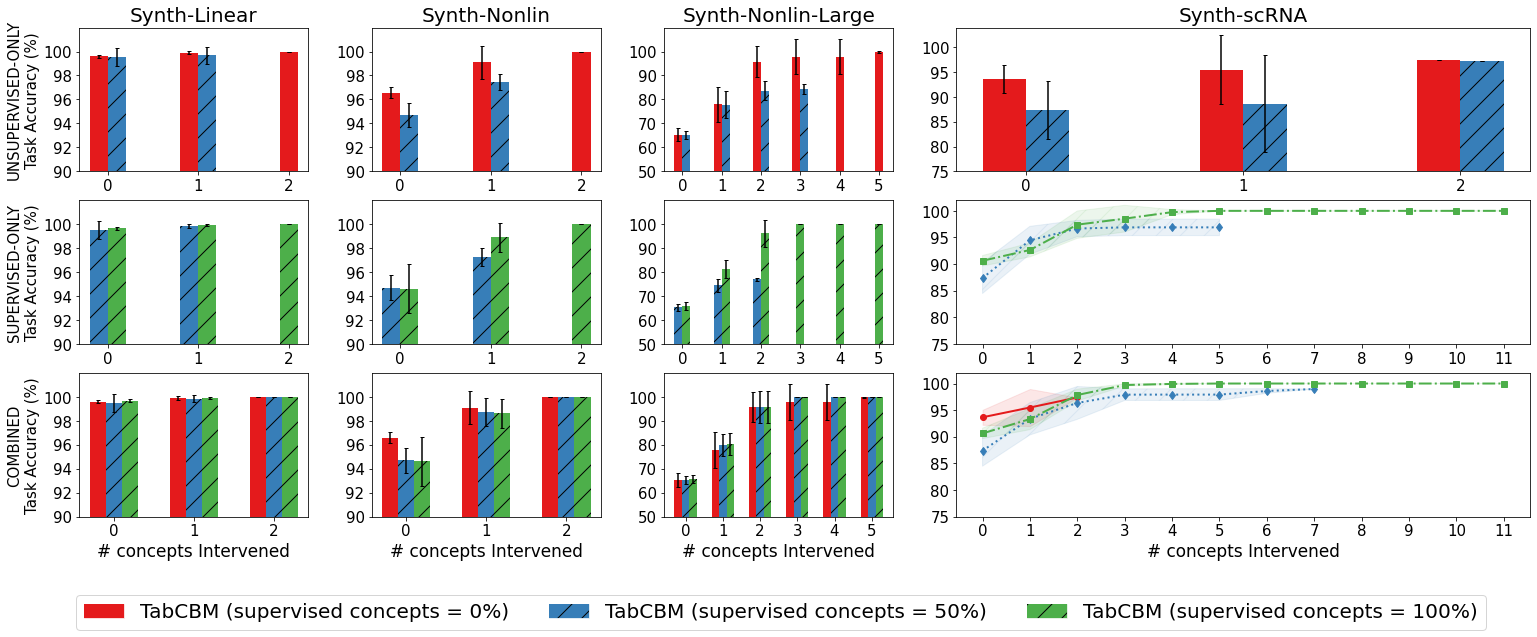

seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 0}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0), 3): 0, (('TabCBM', 0), 4): 0, (('TabCBM', 0), 5): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 1, (('TabCBM', 0.5), 3): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
['TabCBM (supervised concepts = 0%)', 'TabCBM (supervised concepts = 50%)', 'TabCBM (

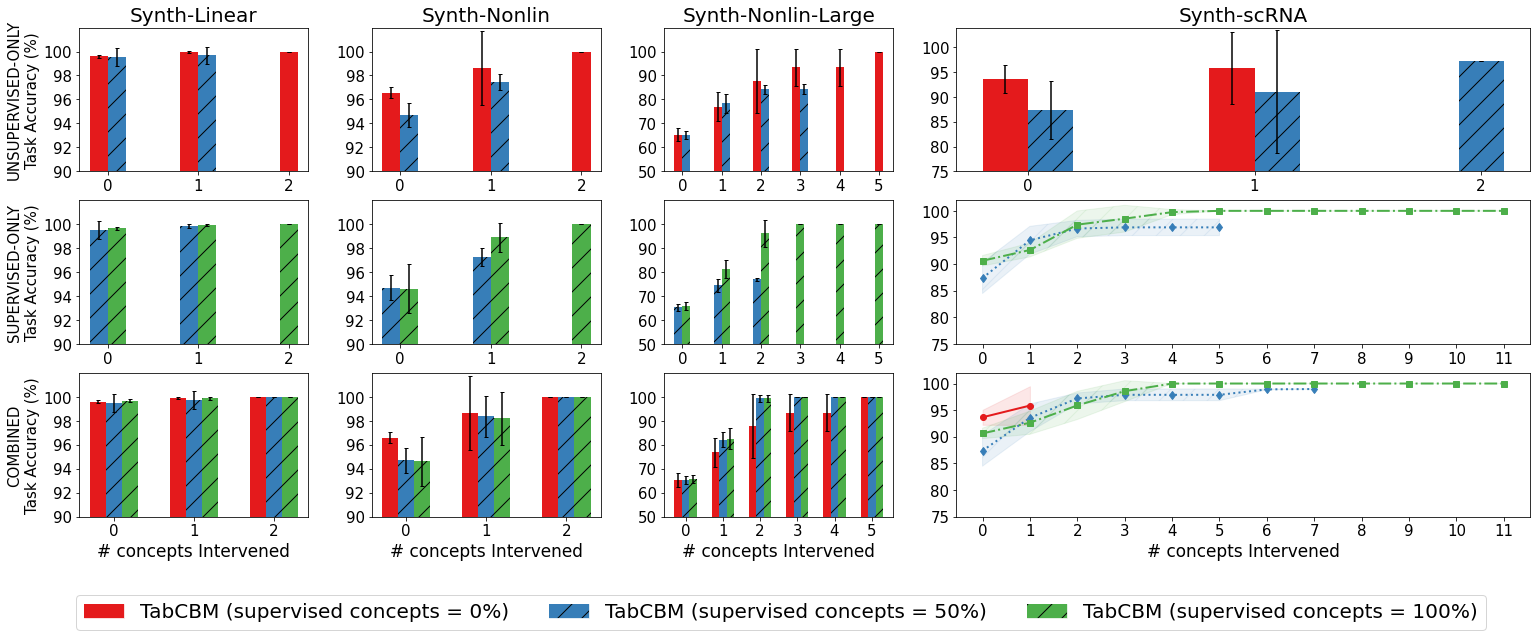

seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 0}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 2, 3: 2, 4: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0), 3): 0, (('TabCBM', 0), 4): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 1, (('TabCBM', 0.5), 3): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
['TabCBM (supervised concepts = 0%)', 'TabCBM (supervised concepts = 50%)', 'TabCBM (supervised concepts = 100%)']

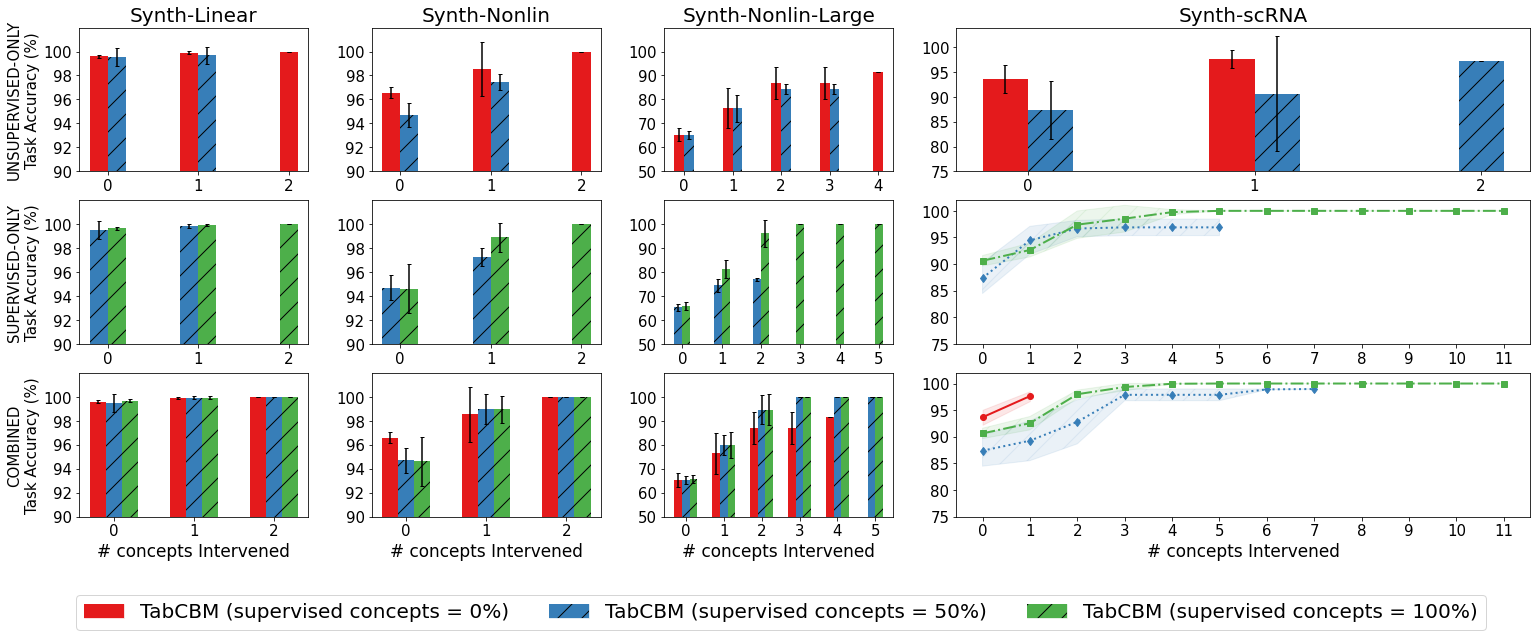

seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 2, 3: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1, (('TabCBM', 0.5), 2): 1, (('TabCBM', 0.5), 3): 0}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
seen_x_val = defaultdict(<class 'int'>, {0: 2, 1: 2, 2: 1})
count_x_val = {(('TabCBM', 0), 0): 0, (('TabCBM', 0), 1): 0, (('TabCBM', 0), 2): 0, (('TabCBM', 0.5), 0): 1, (('TabCBM', 0.5), 1): 1}
['TabCBM (supervised concepts = 0%)', 'TabCBM (supervised concepts = 50%)', 'TabCBM (supervised concepts = 100%)']


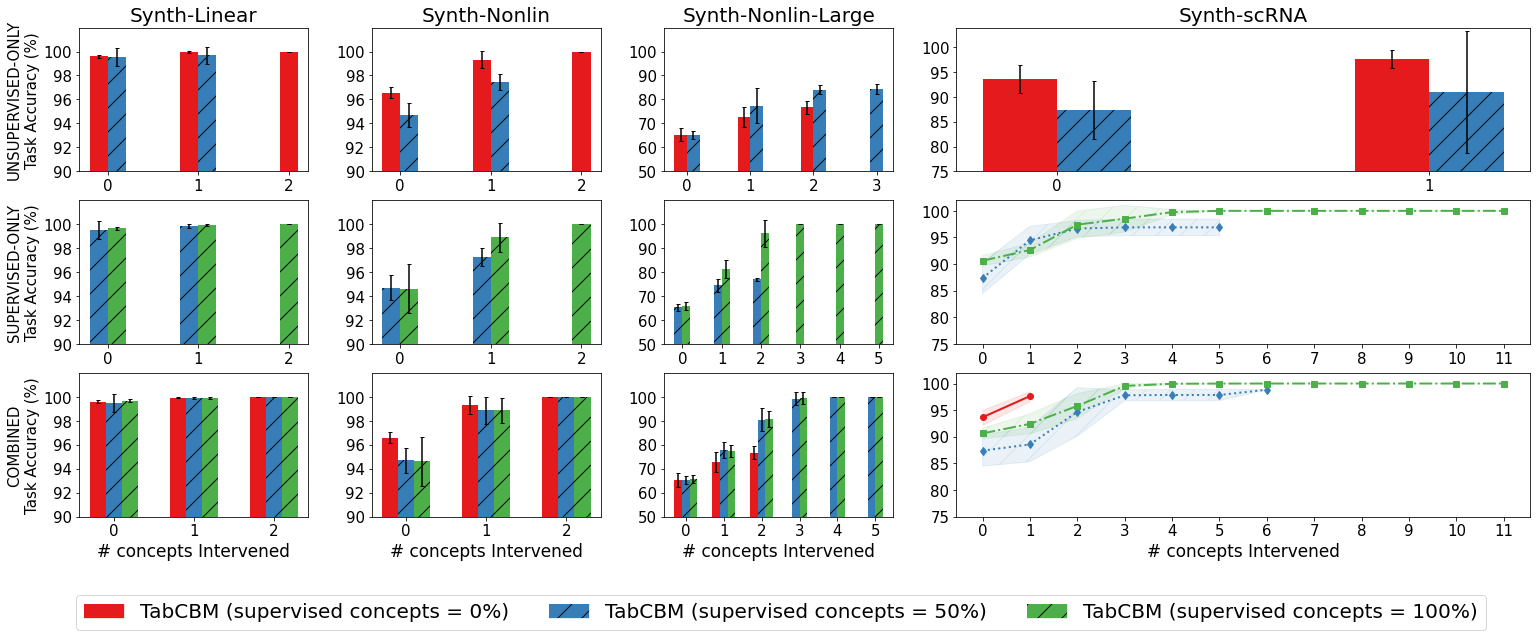

In [86]:
ds_names = [
    ('single_cell', 'Synth-scRNA', 11),
    ('synth_nonlin_complex', 'Synth-Nonlin-Large', 5),
    ('synth_nonlin', 'Synth-Nonlin', 2),
    ('synth_linear', 'Synth-Linear', 2),
]
percent_styles = [
    (0, 'solid', 'o', None),
#     (0.25, 'dashed', 'x', '/'),
    (0.5, 'dotted', 'd', '/'),
#     (0.75, 'dashdot', 's', 'o'),
    (1, 'dashdot', 's', '/'),
]
model_names = [
      'TabCBM',
]
frac_data = 1 #[0.25, 1]
threshs = [0.7, 0.75, 0.8, 0.85] #[0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75,0.8, 0.85]
for thresh in threshs:
    labels = []
    handles = []
    alpha = 0.1
    font = 20
    bar_width = 0.2
    color_map = {}
    clrs = sns.color_palette("Set1", 10)
    fig, axs = plt.subplots(
        3,
        len(ds_names),
        figsize=(26, 3*3),
        gridspec_kw={'width_ratios': [1, 1, 1, 2.5]},
        squeeze=False,
    )
    
    for ds_idx, (ds_name, ds_pretty_name, n_concepts) in enumerate(ds_names):
        ax = axs[0, len(ds_names) - ds_idx - 1]
        metric_fn = lambda concept_ints, thresh: f'unsup_acc_intervention_{concept_ints}_thresh_{thresh}'
        
        seen_x_val = defaultdict(int)
        count_x_val = {}
        for model_name in model_names:
            for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                percent_styles
            ):
                used_metric_fn = metric_fn
                sup_concepts = int(np.floor(n_concepts * percent))
                curr_metrics = results[ds_name][model_name]
                if frac_data == 0 or percent == 0:
                    # Then because supervision is not provided, we will
                    # simply always use the 0% supervised dataset for consistency
                    curr_metrics = curr_metrics[(0, 0)]
                    used_metric_fn = lambda concept_ints, thresh: f'acc_intervention_{concept_ints}_thresh_{thresh}'
                elif percent == 1:
                    continue
                elif (sup_concepts, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                elif (sup_concepts + 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                elif (sup_concepts - 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                else:
                    continue
                key = (model_name, percent)
                for concept_ints in range(n_concepts + 1):
                    if concept_ints == 0:
                        mean, std = curr_metrics['acc']
                    elif used_metric_fn(concept_ints, thresh) in curr_metrics:
                        mean, std = curr_metrics[used_metric_fn(concept_ints, thresh)]
                    else:
                        continue
                    count_x_val[(key, concept_ints)] = seen_x_val[concept_ints]
                    seen_x_val[concept_ints] += 1
        print("seen_x_val =", seen_x_val)
        print("count_x_val =", count_x_val)
        for model_name in model_names:
            seen = set()
            for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                percent_styles
            ):
                used_metric_fn = metric_fn
                sup_concepts = int(np.floor(n_concepts * percent))
                og_frac_data = frac_data
                curr_metrics = results[ds_name][model_name]
                if frac_data == 0 or percent == 0:
                    # Then because supervision is not provided, we will
                    # simply always use the 0% supervised dataset for consistency
                    curr_metrics = curr_metrics[(0, 0)]
                    used_metric_fn = lambda concept_ints, thresh: f'acc_intervention_{concept_ints}_thresh_{thresh}'
                elif percent == 1:
                    continue
                elif (sup_concepts, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                elif (sup_concepts + 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                elif (sup_concepts - 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                else:
                    continue
                key = (model_name, percent)
                if key not in color_map:
                    color_map[key] = clrs[len(color_map)]
                color = color_map[key]
                y_means = []
                y_stds = []
                x_vals = []
                for concept_ints in range(n_concepts + 1):
                    if concept_ints == 0:
                        mean, std = curr_metrics['acc']
                    elif used_metric_fn(concept_ints, thresh) in curr_metrics:
                        mean, std = curr_metrics[used_metric_fn(concept_ints, thresh)]
                    else:
                        continue
                    y_means.append(mean)
                    y_stds.append(std)
                    x_vals.append(concept_ints)
                x_vals = np.array(x_vals)
                y_means = 100 * np.array(y_means)
                y_stds = 100 * np.array(y_stds)
                offset = np.array([
                    seen_x_val[x] * bar_width/2 for x in x_vals
                ])
                p1 = ax.bar(
                    x=x_vals + np.array([count_x_val[(key, x)] * bar_width for x in x_vals]) - offset,
                    height=y_means,
                    width=bar_width,
                    align='edge',
                    color=color,
                    linewidth=2,
                    capsize=2,
                    yerr=2*y_stds,
                    hatch=None if frac_data == 0 or percent == 0 else "/"
                )
                if n_concepts == 2:
                    low_lim = 90
                    ax.set_ylim((low_lim, 102)) #(65, 120))
                elif n_concepts == 5:
                    low_lim = 50
                    ax.set_ylim((low_lim, 110)) #((75, 110))
                else:
                    low_lim = 75
                    ax.set_ylim((low_lim, 104)) #((75, 110))
                n_ticks = 5
                ticks = np.arange(low_lim, 101, (100 - low_lim)/5)
                ax.set_yticks(
                    ticks,
                    [f'{int(j)}'  if int(j) == j else f'{i:.2f}' for j in ticks],
                    fontsize=(0.75 * font),
                )
                if frac_idx == 0:
                    ax.set_title(ds_pretty_name, fontsize=font)
                if n_concepts > 5:
                    ax.set_xticks(
                        np.array(list(seen_x_val.keys())),
                        [f'{int(j)}' for j in seen_x_val.keys()], fontsize=(0.75 * font)
                    )
                else:
                    ax.set_xticks(
#                         np.array(list(seen_x_val.keys())) + np.array(list(map(lambda x: seen_x_val[x]//2, seen_x_val.keys()))) * bar_width,
                        [x for x in sorted(seen_x_val.keys())],
                        [f'{int(j)}' for j in seen_x_val.keys()], fontsize=(0.75 * font)
                    )

                if len(ds_names) - ds_idx - 1 == 0:
                    ax.set_ylabel(
                        (
                            f'UNSUPERVISED-ONLY\nTask Accuracy (%)'
                        ),
                        fontsize=(0.75 * font),
                    )
                p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
        
        
        
        
        
        
        
        ax = axs[1, len(ds_names) - ds_idx - 1]
        metric_fn = lambda concept_ints, thresh: f'sup_acc_intervention_{concept_ints}'
#         metric_fn = lambda concept_ints, thresh: f'unsup_acc_intervention_{concept_ints}_thresh_{thresh}'

        seen_x_val = defaultdict(int)
        count_x_val = {}
        for model_name in model_names:
            for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                percent_styles
            ):
                sup_concepts = int(np.floor(n_concepts * percent))
                curr_metrics = results[ds_name][model_name]
                if frac_data == 0 or percent == 0:
                    # Then because supervision is not provided, we will
                    # simply always use the 0% supervised dataset for consistency
#                     curr_metrics = curr_metrics[(0, 0)]
                    continue
                elif (sup_concepts, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                elif (sup_concepts + 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                elif (sup_concepts - 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                else:
                    continue
                key = (model_name, percent)
                for concept_ints in range(n_concepts + 1):
                    if concept_ints == 0:
                        mean, std = curr_metrics['acc']
                    elif metric_fn(concept_ints, thresh) in curr_metrics:
                        mean, std = curr_metrics[metric_fn(concept_ints, thresh)]
                    else:
                        continue
                    count_x_val[(key, concept_ints)] = seen_x_val[concept_ints]
                    seen_x_val[concept_ints] += 1
        for model_name in model_names:
            seen = set()
            for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                percent_styles
            ):
                sup_concepts = int(np.floor(n_concepts * percent))
                og_frac_data = frac_data
                curr_metrics = results[ds_name][model_name]
                if frac_data == 0 or percent == 0:
                    # Then because supervision is not provided, we will
                    # simply always use the 0% supervised dataset for consistency
#                     curr_metrics = curr_metrics[(0, 0)]
                    continue
                elif (sup_concepts, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                elif (sup_concepts + 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                elif (sup_concepts - 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                else:
                    continue
                key = (model_name, percent)
                if key not in color_map:
                    color_map[key] = clrs[len(color_map)]
                color = color_map[key]
                y_means = []
                y_stds = []
                x_vals = []
                for concept_ints in range(n_concepts + 1):
                    if concept_ints == 0:
                        mean, std = curr_metrics['acc']
                    elif metric_fn(concept_ints, thresh) in curr_metrics:
                        mean, std = curr_metrics[metric_fn(concept_ints, thresh)]
                    else:
                        continue
                    y_means.append(mean)
                    y_stds.append(std)
                    x_vals.append(concept_ints)
                x_vals = np.array(x_vals)
                y_means = 100 * np.array(y_means)
                y_stds = 100 * np.array(y_stds)
                if n_concepts > 5:
                    p1 = ax.plot(
                        x_vals,
                        y_means,
                        color=color,
                        linestyle=line_style,
                        linewidth=2,
                        marker=mark_style,
                    )
                    ax.fill_between(
                        x_vals,
                        y_means - y_stds,
                        y_means + y_stds,
                        color=color,
                        alpha=alpha,
                        hatch=hatch_style,
                    )
                    if n_concepts == 2:
                        low_lim = 90
                        ax.set_ylim((low_lim, 102)) #(65, 120))
                    elif n_concepts == 5:
                        low_lim = 50
                        ax.set_ylim((low_lim, 110)) #((75, 110))
                    else:
                        low_lim = 75
                        ax.set_ylim((low_lim, 102)) #((75, 110))
                    n_ticks = 5
                    ticks = np.arange(low_lim, 101, (100 - low_lim)/5)
                    ax.set_yticks(
                        ticks,
                        [f'{int(j)}'  if int(j) == j else f'{i:.2f}' for j in ticks],
                        fontsize=(0.75 * font),
                    )
                else:
                    offset = np.array([
                        seen_x_val[x] * bar_width/2 for x in x_vals
                    ])
                    p1 = ax.bar(
                        x=x_vals + np.array([count_x_val[(key, x)] * bar_width for x in x_vals]) - offset,
                        height=y_means,
                        width=bar_width,
                        align='edge',
                        color=color,
                        linewidth=2,
                        capsize=2,
                        yerr=2*y_stds,
                        hatch=None if frac_data == 0 or percent == 0 else "/"
                    )
                    if n_concepts == 2:
                        low_lim = 90
                        ax.set_ylim((low_lim, 102)) #(65, 120))
                    elif n_concepts == 5:
                        low_lim = 50
                        ax.set_ylim((low_lim, 110)) #((75, 110))
                    else:
                        low_lim = 80
                        ax.set_ylim((80, 102)) #((75, 110))
                    n_ticks = 5
                    ticks = np.arange(low_lim, 101, (100 - low_lim)/5)
                    ax.set_yticks(
                        ticks,
                        [f'{int(j)}'  if int(j) == j else f'{i:.2f}' for j in ticks],
                        fontsize=(0.75 * font),
                    )
                if n_concepts > 5:
                    ax.set_xticks(
                        x_vals,
                        [f'{int(j)}' for j in x_vals], fontsize=(0.75 * font)
                    )
                else:
                    ax.set_xticks(
#                         x_vals + len(percent_styles)//2 * bar_width,
                        [x for x in sorted(seen_x_val.keys())],
                        [f'{int(j)}' for j in seen_x_val.keys()], fontsize=(0.75 * font)
                    )

                if len(ds_names) - ds_idx - 1 == 0:
                    ax.set_ylabel(
                        (
                            f'SUPERVISED-ONLY\nTask Accuracy (%)'
                        ),
                        fontsize=(0.75 * font),
                    )
                p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
        
        
        
        
        ax = axs[2, len(ds_names) - ds_idx - 1]
        metric_fn = lambda concept_ints, thresh: f'acc_intervention_{concept_ints}_thresh_{thresh}'
    
        seen_x_val = defaultdict(int)
        count_x_val = {}
        for model_name in model_names:
            for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                percent_styles
            ):
                sup_concepts = int(np.floor(n_concepts * percent))
                curr_metrics = results[ds_name][model_name]
                if frac_data == 0 or percent == 0:
                    # Then because supervision is not provided, we will
                    # simply always use the 0% supervised dataset for consistency
                    curr_metrics = curr_metrics[(0, 0)]
                elif (sup_concepts, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                elif (sup_concepts + 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                elif (sup_concepts - 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                else:
                    continue
                key = (model_name, percent)
                for concept_ints in range(n_concepts + 1):
                    if concept_ints == 0:
                        mean, std = curr_metrics['acc']
                    elif metric_fn(concept_ints, thresh) in curr_metrics:
                        mean, std = curr_metrics[metric_fn(concept_ints, thresh)]
                    else:
                        continue
                    count_x_val[(key, concept_ints)] = seen_x_val[concept_ints]
                    seen_x_val[concept_ints] += 1
        for model_name in model_names:
            seen = set()
            for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                percent_styles
            ):
                sup_concepts = int(np.floor(n_concepts * percent))
                og_frac_data = frac_data
                curr_metrics = results[ds_name][model_name]
                if frac_data == 0 or percent == 0:
                    # Then because supervision is not provided, we will
                    # simply always use the 0% supervised dataset for consistency
                    curr_metrics = curr_metrics[(0, 0)]
                elif (sup_concepts, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                elif (sup_concepts + 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                elif (sup_concepts - 1, frac_data) in curr_metrics:
                    curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                else:
                    continue
                key = (model_name, percent)
                if key not in color_map:
                    color_map[key] = clrs[len(color_map)]
                color = color_map[key]
                y_means = []
                y_stds = []
                x_vals = []
                for concept_ints in range(n_concepts + 1):
                    if concept_ints == 0:
                        mean, std = curr_metrics['acc']
                    elif metric_fn(concept_ints, thresh) in curr_metrics:
                        mean, std = curr_metrics[metric_fn(concept_ints, thresh)]
                    else:
                        continue
                    y_means.append(mean)
                    y_stds.append(std)
                    x_vals.append(concept_ints)
                x_vals = np.array(x_vals)
                y_means = 100 * np.array(y_means)
                y_stds = 100 * np.array(y_stds)
                if n_concepts > 5:
                    p1 = ax.plot(
                        x_vals,
                        y_means,
                        color=color,
                        linestyle=line_style,
                        linewidth=2,
                        marker=mark_style,
                    )
                    ax.fill_between(
                        x_vals,
                        y_means - y_stds,
                        y_means + y_stds,
                        color=color,
                        alpha=alpha,
                        hatch=hatch_style,
                    )
                    if n_concepts == 2:
                        low_lim = 90
                        ax.set_ylim((low_lim, 102)) #(65, 120))
                    elif n_concepts == 5:
                        low_lim = 50
                        ax.set_ylim((low_lim, 110)) #((75, 110))
                    else:
                        low_lim = 75
                        ax.set_ylim((low_lim, 102)) #((75, 110))
                    n_ticks = 5
                    ticks = np.arange(low_lim, 101, (100 - low_lim)/5)
                    ax.set_yticks(
                        ticks,
                        [f'{int(j)}'  if int(j) == j else f'{i:.2f}' for j in ticks],
                        fontsize=(0.75 * font),
                    )
                else:
                    offset = np.array([
                        seen_x_val[x] * bar_width/2 for x in x_vals
                    ])
                    p1 = ax.bar(
                        x=x_vals + np.array([count_x_val[(key, x)] * bar_width for x in x_vals]) - offset,
                        height=y_means,
                        width=bar_width,
                        align='edge',
                        color=color,
                        linewidth=2,
                        capsize=2,
                        yerr=2*y_stds,
                        hatch=None if frac_data == 0 or percent == 0 else "/"
                    )
                    if n_concepts == 2:
                        low_lim = 90
                        ax.set_ylim((low_lim, 102)) #(65, 120))
                    elif n_concepts == 5:
                        low_lim = 50
                        ax.set_ylim((low_lim, 110)) #((75, 110))
                    else:
                        low_lim = 80
                        ax.set_ylim((80, 102)) #((75, 110))
                    n_ticks = 5
                    ticks = np.arange(low_lim, 101, (100 - low_lim)/5)
                    ax.set_yticks(
                        ticks,
                        [f'{int(j)}'  if int(j) == j else f'{i:.2f}' for j in ticks],
                        fontsize=(0.75 * font),
                    )
                ax.set_xlabel('# concepts Intervened', fontsize=(0.85 * font))
                if n_concepts > 5:
                    ax.set_xticks(
                        x_vals,
                        [f'{int(j)}' for j in x_vals], fontsize=(0.75 * font)
                    )
                else:
                    ax.set_xticks(
                        [x for x in sorted(seen_x_val.keys())],
                        [f'{int(j)}' for j in seen_x_val.keys()], fontsize=(0.75 * font)
                    )

                if len(ds_names) - ds_idx - 1 == 0:
                    ax.set_ylabel(
                        (
                            f'COMBINED\nTask Accuracy (%)'
                        ),
                        fontsize=(0.75 * font),
                    )
                p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
                name = f"{model_name} (supervised concepts = {int(percent * 100)}%)"
                if name not in labels and ds_idx != 0:
                    handles.append((p2[0], p1[0]))
                    labels.append(f"{model_name} (supervised concepts = {int(percent * 100)}%)")
    print(labels)
    labels = sorted(enumerate(labels), key=lambda x: int(x[1][x[1].index("=") + 1:-2].strip()))
    inds = list(map(lambda x: x[0], labels))
    labels = list(map(lambda x: x[1], labels))
    handles = [handles[x] for x in inds]
    lgd = fig.legend(
        handles,
        labels,
        fontsize=font,
        loc='upper center',
        bbox_to_anchor=(0.5,0.02),
        ncol=4,
    )

    plt.savefig(
        os.path.join(
            "figures/",
            f"concept_interventions_thresh_{thresh}.png",
        ),
        bbox_extra_artists=(lgd,),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"concept_interventions_thresh_{thresh}.pdf",
        ),
        bbox_extra_artists=(lgd,),
        bbox_inches='tight'
    )
    plt.show()

In [18]:
curr_metrics

{'pre_train_acc': (0.9347999999999999, 0.00312409987036265),
 'pre_train_auc': (0.9950578354776727, 0.00042564813100843705),
 'selected_samples': (5999.5, 3464.1016031096237),
 'ss_num_params': (57576.0, 0.0),
 'num_params': (57576.0, 0.0),
 'epochs_trained': (1500.0, 0.0),
 'time_trained': (261.8225978851318, 4.142103774640437),
 'ss_epochs_trained': (50.0, 0.0),
 'ss_time_trained': (6.950851678848267, 0.0680571047122639),
 'acc': (0.9966666666666667, 0.000666666666666671),
 'auc': (0.999983029438267, 4.692425058094277e-06),
 'supervised_concept_idxs': (0.5, 0.5),
 'avg_concept_auc': (0.9999831917072409, 7.568007338816217e-06),
 'best_independent_alignment': (0.5, 0.5),
 'best_ind_alignment_auc': (0.9984399010899876, 0.0001230713247950257),
 'best_independent_alignment_binary': (0.5, 0.5),
 'best_ind_alignment_auc_binary': (0.9993333904847674, 0.00023566351406067258),
 'cas': (0.9965837904458846, 0.0005807561874601948),
 'cas_task': (0.6286401880767439, 0.013329085694921925),
 'best_a